# Computing the scattering matrix of the LXT U-Bend for the low-loss racetrack resonator 

Note: the cost of running the entire notebook is larger than 1 FlexCredit.



In [1]:
import os
import gdstk
import matplotlib.pyplot as plt
import numpy as np

# tidy3D imports
import tidy3d as td
from tidy3d import web, Box
from tidy3d.plugins.mode import ModeSolver

## Setup

We will simulate a directional coupler, similar to the GDS and Parameter scan tutorials.

Let's start by setting up some basic parameters.

In [2]:
# wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

clad_box_1= Box(center=(92, 100, 3.875), size=(195, 220, 7.75))
clad_box_2= Box(center=(92, 100, 4.075), size=(195, 220, 7.75))
clad_slab= Box(center=(92, 100, 0.2), size=(195, 220, 0.4))
override_clad_1 = td.MeshOverrideStructure(geometry=clad_box_1, dl=(0.1,0.1,0.2), name='override_clad_1')
override_clad_2 = td.MeshOverrideStructure(geometry=clad_box_2, dl=(0.1,0.1,0.2), name='override_clad_2')
override_slab = td.MeshOverrideStructure(geometry=clad_slab, dl=(0.1,0.1,0.04), name='override_slab')

# Spatial grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=10, wavelength=lambda0,
                             override_structures=[override_clad_1,override_clad_2,override_slab])


# Simulation time (ps)
sim_time = 5e-12

# space between waveguide and PML
pml_spacing = 1.2

In [3]:
# Define TFLN material as Zelmon1997_Y
LiNbO3 = td.AnisotropicMedium(
    name = 'LiNbO3', 
    xx = td.PoleResidue(name = 'medium_2', frequency_range = [59958491600000, 749481145000000], poles = [[(0 + 14182450644861764j), (0-18957681776986720j)], [(0 + 7745686426535269j), (0-4759724309105923j)], [(0 + 86464275012302.47j), (0-545330182502591.7j)]], ), 
    yy = td.PoleResidue(name = 'medium_3', frequency_range = [59958491600000, 749481145000000], poles = [[(0 + 13165630127713252j), (0-19619422016318290j)], [(0 + 7299001563858286j), (0-2182766417671820.2j)], [(0 + 92344737457068.7j), (0-413441241305915.1j)]], ), 
    zz = td.PoleResidue(name = 'medium_2', frequency_range = [59958491600000, 749481145000000], poles = [[(0 + 14182450644861764j), (0-18957681776986720j)], [(0 + 7745686426535269j), (0-4759724309105923j)], [(0 + 86464275012302.47j), (0-545330182502591.7j)]], )
)

SiO2 = td.PoleResidue(
    name = 'SiO2', 
    frequency_range = [59958491600000, 1998616386666666.8], 
    eps_inf = 1.5385442336875639, 
    poles = [[(-11504139.374277674-15951967407837750j), (7507685.43042605 + 4535416182817100j)], [(-249390.3565044153-172280738540723.53j), (46272.506981344035 + 99704543223121.88j)]]
)

# Define U-Bend structure
slab = td.Structure(
    geometry = td.GeometryGroup(geometries = [td.PolySlab(slab_bounds = [0, 0.2], vertices = [[0, 6], [14.011, 6.028], [24.217, 6.144], [33.706, 6.389], [42.144, 6.762], [50.545, 7.319], [58.236, 8.023], [65.55, 8.896], [72.814, 9.986], [76.424, 10.62], [80.017, 11.316], [83.592, 12.078], [86.823, 12.83], [90.037, 13.64], [93.23, 14.509], [96.401, 15.441], [99.549, 16.435], [102.671, 17.495], [105.765, 18.622], [108.828, 19.816], [111.558, 20.951], [114.557, 22.278], [117.225, 23.534], [120.151, 24.999], [122.748, 26.38], [125.59, 27.985], [128.384, 29.665], [131.125, 31.421], [133.546, 33.065], [136.18, 34.965], [138.498, 36.739], [141.012, 38.782], [143.215, 40.685], [145.595, 42.871], [147.672, 44.901], [149.685, 46.991], [151.63, 49.138], [153.506, 51.343], [155.307, 53.603], [157.033, 55.918], [158.68, 58.286], [160.244, 60.704], [161.723, 63.172], [163.114, 65.686], [164.414, 68.245], [165.621, 70.846], [166.73, 73.485], [167.74, 76.161], [168.552, 78.566], [169.366, 81.301], [170.074, 84.061], [170.672, 86.844], [171.109, 89.333], [171.495, 92.147], [171.74, 94.656], [171.905, 97.485], [171.953, 100], [171.905, 102.515], [171.74, 105.344], [171.495, 107.853], [171.109, 110.667], [170.672, 113.156], [170.074, 115.939], [169.366, 118.699], [168.552, 121.434], [167.74, 123.839], [166.73, 126.515], [165.621, 129.154], [164.414, 131.755], [163.114, 134.314], [161.723, 136.828], [160.244, 139.296], [158.68, 141.714], [157.033, 144.082], [155.307, 146.397], [153.506, 148.657], [151.63, 150.862], [149.685, 153.009], [147.672, 155.099], [145.595, 157.129], [143.215, 159.315], [141.012, 161.218], [138.498, 163.261], [136.18, 165.035], [133.546, 166.935], [131.125, 168.579], [128.384, 170.335], [125.59, 172.015], [122.748, 173.62], [120.151, 175.001], [117.225, 176.466], [114.557, 177.722], [111.558, 179.049], [108.828, 180.184], [105.765, 181.378], [102.671, 182.505], [99.549, 183.565], [96.401, 184.559], [93.23, 185.491], [90.037, 186.36], [86.823, 187.17], [83.592, 187.922], [80.017, 188.684], [76.424, 189.38], [72.814, 190.014], [65.55, 191.104], [58.236, 191.977], [50.545, 192.681], [42.144, 193.238], [33.706, 193.611], [24.217, 193.856], [14.011, 193.972], [0, 194], [0, 206], [14.771, 205.968], [25.814, 205.828], [35.509, 205.554], [44.534, 205.122], [53.227, 204.503], [61.579, 203.683], [65.754, 203.18], [69.578, 202.659], [73.4, 202.078], [77.216, 201.432], [81.025, 200.72], [84.826, 199.937], [88.616, 199.08], [92.05, 198.235], [95.814, 197.229], [99.22, 196.244], [102.609, 195.188], [105.98, 194.06], [109.329, 192.857], [112.654, 191.578], [115.953, 190.22], [118.897, 188.93], [122.137, 187.419], [125.023, 185.989], [128.193, 184.319], [131.011, 182.742], [134.099, 180.909], [137.138, 178.987], [140.124, 176.977], [142.763, 175.092], [145.638, 172.912], [148.17, 170.873], [150.646, 168.762], [153.063, 166.578], [155.418, 164.322], [157.706, 161.994], [159.925, 159.594], [162.07, 157.125], [164.138, 154.586], [166.126, 151.979], [168.029, 149.306], [169.844, 146.568], [171.567, 143.767], [173.018, 141.226], [174.557, 138.312], [175.838, 135.675], [177.179, 132.658], [178.278, 129.934], [179.408, 126.825], [180.313, 124.024], [181.219, 120.836], [181.92, 117.971], [182.521, 115.082], [183.02, 112.169], [183.456, 108.871], [183.731, 105.924], [183.897, 102.965], [183.953, 100], [183.897, 97.035], [183.731, 94.076], [183.456, 91.129], [183.02, 87.831], [182.521, 84.918], [181.92, 82.029], [181.219, 79.164], [180.313, 75.976], [179.408, 73.175], [178.278, 70.066], [177.179, 67.342], [175.838, 64.325], [174.557, 61.688], [173.018, 58.774], [171.567, 56.233], [169.844, 53.432], [168.029, 50.694], [166.126, 48.021], [164.138, 45.414], [162.07, 42.875], [159.925, 40.406], [157.706, 38.006], [155.418, 35.678], [153.063, 33.422], [150.646, 31.238], [148.17, 29.127], [145.638, 27.088], [142.763, 24.908], [140.124, 23.023], [137.138, 21.013], [134.099, 19.091], [131.011, 17.258], [128.193, 15.681], [125.023, 14.011], [122.137, 12.581], [118.897, 11.07], [115.953, 9.78], [112.654, 8.422], [109.329, 7.143], [105.98, 5.94], [102.609, 4.812], [99.22, 3.756], [95.814, 2.771], [92.05, 1.765], [88.616, 0.92], [84.826, 0.063], [81.025, -0.72], [77.216, -1.432], [73.4, -2.078], [69.578, -2.659], [65.754, -3.18], [61.579, -3.683], [53.227, -4.503], [44.534, -5.122], [35.509, -5.554], [25.814, -5.828], [14.771, -5.968], [0, -6]])]), 
    name = 'Slab', 
    medium = LiNbO3
)
# Ridge containing 13 degress sidewall angle
ridge = td.Structure(
    geometry = td.GeometryGroup(geometries = [td.GeometryGroup(geometries = [td.PolySlab(sidewall_angle = 0.22689280275926285, reference_plane = 'bottom', slab_bounds = [0.30000000000000004, 0.4], vertices = [[0, -1.5], [3.427, -1.5], [3.769, -1.499], [5.14, -1.499], [5.483, -1.498], [6.169, -1.498], [6.511, -1.497], [6.854, -1.497], [7.197, -1.496], [7.54, -1.496], [8.226, -1.494], [8.568, -1.494], [10.969, -1.487], [11.312, -1.485], [11.998, -1.483], [12.684, -1.479], [13.027, -1.478], [15.085, -1.466], [15.428, -1.463], [15.771, -1.461], [17.143, -1.449], [17.487, -1.446], [18.173, -1.44], [18.516, -1.436], [18.859, -1.433], [19.202, -1.429], [19.546, -1.425], [20.575, -1.413], [20.918, -1.408], [21.262, -1.403], [21.605, -1.399], [22.291, -1.389], [22.635, -1.384], [22.978, -1.378], [23.321, -1.373], [23.664, -1.367], [24.008, -1.361], [24.694, -1.349], [25.038, -1.342], [25.381, -1.336], [25.724, -1.329], [26.068, -1.322], [26.754, -1.308], [27.098, -1.3], [27.441, -1.293], [27.784, -1.285], [28.128, -1.277], [28.471, -1.268], [28.815, -1.26], [29.501, -1.242], [29.845, -1.233], [30.188, -1.224], [30.532, -1.214], [30.875, -1.205], [31.218, -1.195], [31.562, -1.184], [31.905, -1.174], [32.249, -1.163], [32.592, -1.153], [32.936, -1.141], [33.622, -1.119], [33.966, -1.107], [34.309, -1.095], [34.653, -1.082], [34.996, -1.07], [35.34, -1.057], [35.683, -1.044], [36.027, -1.031], [36.37, -1.017], [36.714, -1.003], [37.057, -0.989], [37.401, -0.975], [37.744, -0.96], [38.087, -0.946], [38.431, -0.93], [38.774, -0.915], [39.118, -0.899], [39.461, -0.883], [39.805, -0.867], [40.148, -0.851], [40.492, -0.834], [40.835, -0.817], [41.178, -0.799], [41.522, -0.782], [41.865, -0.764], [42.209, -0.745], [42.552, -0.727], [42.896, -0.708], [43.239, -0.689], [43.582, -0.669], [43.926, -0.65], [44.269, -0.629], [44.613, -0.609], [45.299, -0.567], [45.643, -0.546], [46.329, -0.502], [46.673, -0.48], [47.702, -0.411], [48.046, -0.387], [48.732, -0.339], [49.075, -0.314], [49.419, -0.289], [49.762, -0.263], [50.105, -0.238], [50.448, -0.211], [50.791, -0.185], [51.135, -0.158], [51.478, -0.131], [52.507, -0.047], [53.536, 0.04], [54.222, 0.1], [55.251, 0.193], [55.593, 0.225], [55.936, 0.257], [56.965, 0.356], [57.307, 0.39], [57.993, 0.458], [58.335, 0.493], [58.678, 0.529], [59.02, 0.565], [59.363, 0.601], [59.705, 0.637], [60.048, 0.674], [60.39, 0.712], [60.733, 0.75], [61.075, 0.788], [61.417, 0.827], [61.76, 0.866], [62.444, 0.946], [63.47, 1.069], [64.154, 1.153], [64.838, 1.239], [65.522, 1.327], [65.864, 1.372], [66.205, 1.417], [66.547, 1.462], [66.888, 1.509], [67.23, 1.555], [67.571, 1.602], [67.913, 1.649], [68.254, 1.697], [68.596, 1.746], [69.278, 1.844], [69.96, 1.944], [70.301, 1.995], [71.324, 2.151], [71.665, 2.204], [72.005, 2.257], [72.346, 2.311], [72.686, 2.365], [73.027, 2.42], [73.367, 2.476], [73.708, 2.532], [74.048, 2.588], [74.388, 2.645], [75.408, 2.819], [75.748, 2.878], [76.088, 2.938], [76.427, 2.998], [76.767, 3.059], [77.106, 3.12], [77.446, 3.182], [77.785, 3.244], [78.124, 3.307], [78.464, 3.371], [79.142, 3.499], [79.48, 3.564], [80.158, 3.696], [80.496, 3.763], [80.835, 3.83], [81.173, 3.898], [81.512, 3.967], [82.188, 4.105], [82.526, 4.176], [82.864, 4.246], [83.201, 4.318], [83.539, 4.39], [83.876, 4.462], [84.214, 4.535], [84.888, 4.683], [85.225, 4.758], [85.899, 4.91], [86.236, 4.987], [86.572, 5.064], [86.908, 5.142], [87.245, 5.22], [87.581, 5.299], [88.253, 5.459], [88.588, 5.54], [88.924, 5.622], [89.259, 5.704], [89.595, 5.787], [89.93, 5.87], [90.265, 5.955], [90.6, 6.039], [90.935, 6.125], [91.269, 6.211], [91.604, 6.297], [91.938, 6.384], [92.272, 6.472], [92.94, 6.65], [93.273, 6.74], [93.607, 6.83], [93.94, 6.921], [94.273, 7.013], [94.939, 7.199], [95.271, 7.292], [95.604, 7.387], [95.936, 7.482], [96.6, 7.674], [96.932, 7.771], [97.263, 7.869], [97.595, 7.967], [97.926, 8.066], [98.588, 8.266], [98.918, 8.367], [99.249, 8.469], [99.909, 8.675], [100.238, 8.779], [100.568, 8.883], [100.897, 8.988], [101.226, 9.094], [101.884, 9.308], [102.213, 9.416], [102.869, 9.634], [103.197, 9.744], [103.524, 9.855], [103.852, 9.967], [104.179, 10.079], [104.506, 10.192], [104.832, 10.306], [105.159, 10.42], [105.485, 10.535], [106.137, 10.767], [107.112, 11.121], [107.437, 11.241], [107.761, 11.361], [108.085, 11.482], [108.733, 11.726], [109.056, 11.849], [109.379, 11.973], [110.025, 12.223], [110.347, 12.349], [110.991, 12.603], [111.633, 12.861], [112.275, 13.121], [112.595, 13.252], [112.915, 13.385], [113.235, 13.517], [113.873, 13.785], [114.192, 13.92], [114.51, 14.056], [115.146, 14.33], [116.097, 14.747], [116.414, 14.888], [116.73, 15.029], [117.046, 15.171], [117.361, 15.314], [117.991, 15.602], [118.305, 15.747], [118.619, 15.893], [119.247, 16.187], [119.56, 16.336], [119.872, 16.485], [120.184, 16.635], [120.808, 16.937], [121.119, 17.089], [121.43, 17.242], [121.74, 17.396], [122.36, 17.706], [122.978, 18.02], [123.594, 18.336], [123.902, 18.496], [124.209, 18.656], [124.516, 18.817], [124.822, 18.979], [125.434, 19.305], [126.044, 19.635], [126.348, 19.801], [126.652, 19.968], [126.955, 20.135], [127.561, 20.473], [127.863, 20.643], [128.164, 20.814], [128.466, 20.985], [128.766, 21.158], [129.067, 21.331], [129.366, 21.505], [129.666, 21.68], [129.965, 21.856], [130.561, 22.21], [131.155, 22.568], [131.452, 22.748], [131.747, 22.928], [132.043, 23.11], [132.338, 23.292], [132.926, 23.66], [133.22, 23.845], [133.513, 24.03], [133.805, 24.217], [134.097, 24.405], [134.388, 24.593], [134.679, 24.782], [134.969, 24.972], [135.259, 25.163], [135.548, 25.354], [135.837, 25.547], [136.125, 25.74], [136.413, 25.934], [136.7, 26.129], [136.986, 26.325], [137.272, 26.522], [137.557, 26.719], [137.842, 26.918], [138.126, 27.117], [138.41, 27.317], [138.693, 27.518], [138.975, 27.719], [139.257, 27.922], [139.538, 28.125], [139.819, 28.33], [140.099, 28.535], [140.657, 28.947], [141.213, 29.363], [141.49, 29.573], [141.766, 29.783], [142.042, 29.994], [142.317, 30.206], [142.591, 30.418], [142.865, 30.632], [143.138, 30.846], [143.682, 31.278], [144.224, 31.712], [144.494, 31.931], [144.763, 32.15], [145.299, 32.592], [145.566, 32.814], [145.833, 33.037], [146.098, 33.26], [146.628, 33.71], [147.154, 34.164], [147.416, 34.391], [147.678, 34.62], [147.939, 34.85], [148.199, 35.08], [148.458, 35.311], [148.716, 35.544], [148.974, 35.776], [149.231, 36.01], [149.488, 36.245], [149.743, 36.48], [149.998, 36.717], [150.252, 36.954], [150.758, 37.43], [151.26, 37.91], [151.76, 38.394], [152.008, 38.637], [152.256, 38.881], [152.503, 39.125], [152.995, 39.617], [153.239, 39.864], [153.483, 40.112], [153.726, 40.361], [153.968, 40.61], [154.209, 40.861], [154.449, 41.112], [154.689, 41.364], [155.165, 41.87], [155.402, 42.125], [155.638, 42.38], [155.874, 42.636], [156.108, 42.893], [156.574, 43.409], [156.806, 43.669], [157.036, 43.929], [157.266, 44.19], [157.724, 44.714], [157.951, 44.978], [158.177, 45.242], [158.402, 45.507], [158.627, 45.773], [158.85, 46.039], [159.073, 46.307], [159.295, 46.575], [159.735, 47.113], [159.954, 47.384], [160.172, 47.655], [160.389, 47.927], [160.605, 48.2], [160.82, 48.474], [161.034, 48.748], [161.247, 49.023], [161.459, 49.299], [161.67, 49.576], [161.88, 49.854], [162.089, 50.132], [162.297, 50.411], [162.504, 50.691], [162.71, 50.971], [162.915, 51.253], [163.119, 51.535], [163.322, 51.817], [163.524, 52.101], [163.724, 52.385], [163.924, 52.67], [164.123, 52.956], [164.321, 53.243], [164.517, 53.53], [164.713, 53.818], [164.908, 54.107], [165.101, 54.396], [165.485, 54.978], [165.675, 55.269], [165.864, 55.562], [166.052, 55.855], [166.239, 56.149], [166.425, 56.443], [166.61, 56.738], [166.793, 57.034], [166.976, 57.331], [167.157, 57.628], [167.337, 57.927], [167.517, 58.225], [167.871, 58.825], [168.047, 59.126], [168.221, 59.427], [168.395, 59.729], [168.567, 60.032], [168.738, 60.336], [168.908, 60.64], [169.077, 60.945], [169.244, 61.251], [169.41, 61.557], [169.576, 61.864], [169.74, 62.171], [169.902, 62.479], [170.064, 62.788], [170.224, 63.097], [170.383, 63.408], [170.541, 63.718], [170.698, 64.03], [170.853, 64.342], [171.007, 64.654], [171.16, 64.967], [171.312, 65.281], [171.612, 65.911], [171.76, 66.226], [172.052, 66.86], [172.196, 67.177], [172.339, 67.495], [172.621, 68.133], [172.76, 68.453], [172.897, 68.773], [173.034, 69.094], [173.169, 69.415], [173.303, 69.737], [173.435, 70.06], [173.566, 70.383], [173.696, 70.707], [173.825, 71.031], [173.952, 71.356], [174.078, 71.681], [174.326, 72.333], [174.447, 72.66], [174.568, 72.988], [174.687, 73.315], [174.805, 73.644], [174.921, 73.973], [175.036, 74.302], [175.15, 74.632], [175.262, 74.962], [175.373, 75.293], [175.482, 75.624], [175.591, 75.956], [175.697, 76.288], [175.803, 76.621], [175.906, 76.954], [176.009, 77.288], [176.11, 77.622], [176.21, 77.956], [176.308, 78.291], [176.405, 78.627], [176.5, 78.962], [176.594, 79.298], [176.686, 79.635], [176.777, 79.972], [176.867, 80.309], [176.955, 80.647], [177.042, 80.985], [177.127, 81.324], [177.211, 81.663], [177.293, 82.002], [177.374, 82.342], [177.453, 82.682], [177.531, 83.022], [177.607, 83.363], [177.682, 83.704], [177.755, 84.045], [177.827, 84.387], [177.898, 84.729], [177.967, 85.071], [178.034, 85.414], [178.1, 85.757], [178.164, 86.1], [178.227, 86.444], [178.288, 86.788], [178.348, 87.132], [178.406, 87.476], [178.463, 87.821], [178.518, 88.166], [178.572, 88.511], [178.624, 88.857], [178.674, 89.202], [178.723, 89.548], [178.77, 89.894], [178.816, 90.241], [178.861, 90.587], [178.903, 90.934], [178.944, 91.281], [178.984, 91.628], [179.022, 91.975], [179.058, 92.323], [179.093, 92.671], [179.126, 93.019], [179.158, 93.367], [179.188, 93.715], [179.216, 94.063], [179.243, 94.412], [179.269, 94.76], [179.292, 95.109], [179.314, 95.458], [179.335, 95.807], [179.371, 96.505], [179.386, 96.854], [179.4, 97.204], [179.412, 97.553], [179.423, 97.902], [179.432, 98.252], [179.439, 98.601], [179.445, 98.951], [179.449, 99.301], [179.452, 99.65], [179.453, 100], [179.452, 100.35], [179.449, 100.699], [179.445, 101.049], [179.439, 101.399], [179.432, 101.748], [179.423, 102.098], [179.412, 102.447], [179.4, 102.796], [179.386, 103.146], [179.371, 103.495], [179.335, 104.193], [179.314, 104.542], [179.292, 104.891], [179.269, 105.24], [179.243, 105.588], [179.216, 105.937], [179.188, 106.285], [179.158, 106.633], [179.126, 106.981], [179.093, 107.329], [179.058, 107.677], [179.022, 108.025], [178.984, 108.372], [178.944, 108.719], [178.903, 109.066], [178.861, 109.413], [178.816, 109.759], [178.77, 110.106], [178.723, 110.452], [178.674, 110.798], [178.624, 111.143], [178.572, 111.489], [178.518, 111.834], [178.463, 112.179], [178.406, 112.524], [178.348, 112.868], [178.288, 113.212], [178.227, 113.556], [178.164, 113.9], [178.1, 114.243], [178.034, 114.586], [177.967, 114.929], [177.898, 115.271], [177.827, 115.613], [177.755, 115.955], [177.682, 116.296], [177.607, 116.637], [177.531, 116.978], [177.453, 117.318], [177.374, 117.658], [177.293, 117.998], [177.211, 118.337], [177.127, 118.676], [177.042, 119.015], [176.955, 119.353], [176.867, 119.691], [176.777, 120.028], [176.686, 120.365], [176.594, 120.702], [176.5, 121.038], [176.405, 121.373], [176.308, 121.709], [176.21, 122.044], [176.11, 122.378], [176.009, 122.712], [175.906, 123.046], [175.803, 123.379], [175.697, 123.712], [175.591, 124.044], [175.482, 124.376], [175.373, 124.707], [175.262, 125.038], [175.15, 125.368], [175.036, 125.698], [174.921, 126.027], [174.805, 126.356], [174.687, 126.685], [174.568, 127.012], [174.447, 127.34], [174.326, 127.667], [174.078, 128.319], [173.952, 128.644], [173.825, 128.969], [173.696, 129.293], [173.566, 129.617], [173.435, 129.94], [173.303, 130.263], [173.169, 130.585], [173.034, 130.906], [172.897, 131.227], [172.76, 131.547], [172.621, 131.867], [172.339, 132.505], [172.196, 132.823], [172.052, 133.14], [171.76, 133.774], [171.612, 134.089], [171.312, 134.719], [171.16, 135.033], [171.007, 135.346], [170.853, 135.658], [170.698, 135.97], [170.541, 136.282], [170.383, 136.592], [170.224, 136.903], [170.064, 137.212], [169.902, 137.521], [169.74, 137.829], [169.576, 138.136], [169.41, 138.443], [169.244, 138.749], [169.077, 139.055], [168.908, 139.36], [168.738, 139.664], [168.567, 139.968], [168.395, 140.271], [168.221, 140.573], [168.047, 140.874], [167.871, 141.175], [167.517, 141.775], [167.337, 142.073], [167.157, 142.372], [166.976, 142.669], [166.793, 142.966], [166.61, 143.262], [166.425, 143.557], [166.239, 143.851], [166.052, 144.145], [165.864, 144.438], [165.675, 144.731], [165.485, 145.022], [165.101, 145.604], [164.908, 145.893], [164.713, 146.182], [164.517, 146.47], [164.321, 146.757], [164.123, 147.044], [163.924, 147.33], [163.724, 147.615], [163.524, 147.899], [163.322, 148.183], [163.119, 148.465], [162.915, 148.747], [162.71, 149.029], [162.504, 149.309], [162.297, 149.589], [162.089, 149.868], [161.88, 150.146], [161.67, 150.424], [161.459, 150.701], [161.247, 150.977], [161.034, 151.252], [160.82, 151.526], [160.605, 151.8], [160.389, 152.073], [160.172, 152.345], [159.954, 152.616], [159.735, 152.887], [159.295, 153.425], [159.073, 153.693], [158.85, 153.961], [158.627, 154.227], [158.402, 154.493], [158.177, 154.758], [157.951, 155.022], [157.724, 155.286], [157.266, 155.81], [157.036, 156.071], [156.806, 156.331], [156.574, 156.591], [156.108, 157.107], [155.874, 157.364], [155.638, 157.62], [155.402, 157.875], [155.165, 158.13], [154.689, 158.636], [154.449, 158.888], [154.209, 159.139], [153.968, 159.39], [153.726, 159.639], [153.483, 159.888], [153.239, 160.136], [152.995, 160.383], [152.503, 160.875], [152.256, 161.119], [152.008, 161.363], [151.76, 161.606], [151.26, 162.09], [150.758, 162.57], [150.252, 163.046], [149.998, 163.283], [149.743, 163.52], [149.488, 163.755], [149.231, 163.99], [148.974, 164.224], [148.716, 164.456], [148.458, 164.689], [148.199, 164.92], [147.939, 165.15], [147.678, 165.38], [147.416, 165.609], [147.154, 165.836], [146.628, 166.29], [146.098, 166.74], [145.833, 166.963], [145.566, 167.186], [145.299, 167.408], [144.763, 167.85], [144.494, 168.069], [144.224, 168.288], [143.682, 168.722], [143.138, 169.154], [142.865, 169.368], [142.591, 169.582], [142.317, 169.794], [142.042, 170.006], [141.766, 170.217], [141.49, 170.427], [141.213, 170.637], [140.657, 171.053], [140.099, 171.465], [139.819, 171.67], [139.538, 171.875], [139.257, 172.078], [138.975, 172.281], [138.693, 172.482], [138.41, 172.683], [138.126, 172.883], [137.842, 173.082], [137.557, 173.281], [137.272, 173.478], [136.986, 173.675], [136.7, 173.871], [136.413, 174.066], [136.125, 174.26], [135.837, 174.453], [135.548, 174.646], [135.259, 174.837], [134.969, 175.028], [134.679, 175.218], [134.388, 175.407], [134.097, 175.595], [133.805, 175.783], [133.513, 175.97], [133.22, 176.155], [132.926, 176.34], [132.338, 176.708], [132.043, 176.89], [131.747, 177.072], [131.452, 177.252], [131.155, 177.432], [130.561, 177.79], [129.965, 178.144], [129.666, 178.32], [129.366, 178.495], [129.067, 178.669], [128.766, 178.842], [128.466, 179.015], [128.164, 179.186], [127.863, 179.357], [127.561, 179.527], [126.955, 179.865], [126.652, 180.032], [126.348, 180.199], [126.044, 180.365], [125.434, 180.695], [124.822, 181.021], [124.516, 181.183], [124.209, 181.344], [123.902, 181.504], [123.594, 181.664], [122.978, 181.98], [122.36, 182.294], [121.74, 182.604], [121.43, 182.758], [121.119, 182.911], [120.808, 183.063], [120.184, 183.365], [119.872, 183.515], [119.56, 183.664], [119.247, 183.813], [118.619, 184.107], [118.305, 184.253], [117.991, 184.398], [117.361, 184.686], [117.046, 184.829], [116.73, 184.971], [116.414, 185.112], [116.097, 185.253], [115.146, 185.67], [114.51, 185.944], [114.192, 186.08], [113.873, 186.215], [113.235, 186.483], [112.915, 186.615], [112.595, 186.748], [112.275, 186.879], [111.633, 187.139], [110.991, 187.397], [110.347, 187.651], [110.025, 187.777], [109.379, 188.027], [109.056, 188.151], [108.733, 188.274], [108.085, 188.518], [107.761, 188.639], [107.437, 188.759], [107.112, 188.879], [106.137, 189.233], [105.485, 189.465], [105.159, 189.58], [104.832, 189.694], [104.506, 189.808], [104.179, 189.921], [103.852, 190.033], [103.524, 190.145], [103.197, 190.256], [102.869, 190.366], [102.213, 190.584], [101.884, 190.692], [101.226, 190.906], [100.897, 191.012], [100.568, 191.117], [100.238, 191.221], [99.909, 191.325], [99.249, 191.531], [98.918, 191.633], [98.588, 191.734], [97.926, 191.934], [97.595, 192.033], [97.263, 192.131], [96.932, 192.229], [96.6, 192.326], [95.936, 192.518], [95.604, 192.613], [95.271, 192.708], [94.939, 192.801], [94.273, 192.987], [93.94, 193.079], [93.607, 193.17], [93.273, 193.26], [92.94, 193.35], [92.272, 193.528], [91.938, 193.616], [91.604, 193.703], [91.269, 193.789], [90.935, 193.875], [90.6, 193.961], [90.265, 194.045], [89.93, 194.13], [89.595, 194.213], [89.259, 194.296], [88.924, 194.378], [88.588, 194.46], [88.253, 194.541], [87.581, 194.701], [87.245, 194.78], [86.908, 194.858], [86.572, 194.936], [86.236, 195.013], [85.899, 195.09], [85.225, 195.242], [84.888, 195.317], [84.214, 195.465], [83.876, 195.538], [83.539, 195.61], [83.201, 195.682], [82.864, 195.754], [82.526, 195.824], [82.188, 195.895], [81.512, 196.033], [81.173, 196.102], [80.835, 196.17], [80.496, 196.237], [80.158, 196.304], [79.48, 196.436], [79.142, 196.501], [78.464, 196.629], [78.124, 196.693], [77.785, 196.756], [77.446, 196.818], [77.106, 196.88], [76.767, 196.941], [76.427, 197.002], [76.088, 197.062], [75.748, 197.122], [75.408, 197.181], [74.388, 197.355], [74.048, 197.412], [73.708, 197.468], [73.367, 197.524], [73.027, 197.58], [72.686, 197.635], [72.346, 197.689], [72.005, 197.743], [71.665, 197.796], [71.324, 197.849], [70.301, 198.005], [69.96, 198.056], [69.278, 198.156], [68.596, 198.254], [68.254, 198.303], [67.913, 198.351], [67.571, 198.398], [67.23, 198.445], [66.888, 198.491], [66.547, 198.538], [66.205, 198.583], [65.864, 198.628], [65.522, 198.673], [64.838, 198.761], [64.154, 198.847], [63.47, 198.931], [62.444, 199.054], [61.76, 199.134], [61.417, 199.173], [61.075, 199.212], [60.733, 199.25], [60.39, 199.288], [60.048, 199.326], [59.705, 199.363], [59.363, 199.399], [59.02, 199.435], [58.678, 199.471], [58.335, 199.507], [57.993, 199.542], [57.307, 199.61], [56.965, 199.644], [55.936, 199.743], [55.593, 199.775], [55.251, 199.807], [54.222, 199.9], [53.536, 199.96], [52.507, 200.047], [51.478, 200.131], [51.135, 200.158], [50.791, 200.185], [50.448, 200.211], [50.105, 200.238], [49.762, 200.263], [49.419, 200.289], [49.075, 200.314], [48.732, 200.339], [48.046, 200.387], [47.702, 200.411], [46.673, 200.48], [46.329, 200.502], [45.643, 200.546], [45.299, 200.567], [44.613, 200.609], [44.269, 200.629], [43.926, 200.65], [43.582, 200.669], [43.239, 200.689], [42.896, 200.708], [42.552, 200.727], [42.209, 200.745], [41.865, 200.764], [41.522, 200.782], [41.178, 200.799], [40.835, 200.817], [40.492, 200.834], [40.148, 200.851], [39.805, 200.867], [39.461, 200.883], [39.118, 200.899], [38.774, 200.915], [38.431, 200.93], [38.087, 200.946], [37.744, 200.96], [37.401, 200.975], [37.057, 200.989], [36.714, 201.003], [36.37, 201.017], [36.027, 201.031], [35.683, 201.044], [35.34, 201.057], [34.996, 201.07], [34.653, 201.082], [34.309, 201.095], [33.966, 201.107], [33.622, 201.119], [32.936, 201.141], [32.592, 201.153], [32.249, 201.163], [31.905, 201.174], [31.562, 201.184], [31.218, 201.195], [30.875, 201.205], [30.532, 201.214], [30.188, 201.224], [29.845, 201.233], [29.501, 201.242], [28.815, 201.26], [28.471, 201.268], [28.128, 201.277], [27.784, 201.285], [27.441, 201.293], [27.098, 201.3], [26.754, 201.308], [26.068, 201.322], [25.724, 201.329], [25.381, 201.336], [25.038, 201.342], [24.694, 201.349], [24.008, 201.361], [23.664, 201.367], [23.321, 201.373], [22.978, 201.378], [22.635, 201.384], [22.291, 201.389], [21.605, 201.399], [21.262, 201.403], [20.918, 201.408], [20.575, 201.413], [19.546, 201.425], [19.202, 201.429], [18.859, 201.433], [18.516, 201.436], [18.173, 201.44], [17.487, 201.446], [17.143, 201.449], [15.771, 201.461], [15.428, 201.463], [15.085, 201.466], [13.027, 201.478], [12.684, 201.479], [11.998, 201.483], [11.312, 201.485], [10.969, 201.487], [8.568, 201.494], [8.226, 201.494], [7.54, 201.496], [7.197, 201.496], [6.854, 201.497], [6.511, 201.497], [6.169, 201.498], [5.483, 201.498], [5.14, 201.499], [3.769, 201.499], [3.427, 201.5], [0, 201.5], [0, 198.5], [3.426, 198.5], [3.768, 198.499], [5.138, 198.499], [5.48, 198.498], [6.165, 198.498], [6.508, 198.497], [6.85, 198.497], [7.192, 198.496], [7.535, 198.496], [8.219, 198.494], [8.562, 198.494], [9.246, 198.492], [9.589, 198.491], [10.273, 198.489], [10.616, 198.488], [10.958, 198.487], [11.3, 198.485], [11.642, 198.484], [11.985, 198.483], [12.327, 198.481], [12.669, 198.48], [13.011, 198.478], [13.354, 198.476], [15.064, 198.466], [15.406, 198.463], [15.749, 198.461], [16.775, 198.452], [17.117, 198.45], [17.459, 198.446], [18.143, 198.44], [18.485, 198.436], [18.827, 198.433], [20.537, 198.413], [20.879, 198.408], [21.221, 198.404], [21.905, 198.394], [22.246, 198.389], [22.93, 198.379], [23.614, 198.367], [23.956, 198.362], [24.297, 198.355], [24.981, 198.343], [25.323, 198.336], [25.665, 198.33], [26.006, 198.323], [26.348, 198.316], [26.69, 198.308], [27.031, 198.301], [27.715, 198.285], [28.056, 198.277], [28.74, 198.261], [29.081, 198.252], [29.423, 198.243], [29.764, 198.234], [30.106, 198.225], [30.447, 198.215], [30.789, 198.206], [31.13, 198.196], [31.472, 198.186], [31.813, 198.175], [32.155, 198.165], [32.496, 198.154], [32.838, 198.143], [33.179, 198.132], [33.52, 198.12], [33.862, 198.109], [34.203, 198.097], [34.544, 198.084], [34.886, 198.072], [35.568, 198.046], [35.91, 198.033], [36.251, 198.02], [37.274, 197.978], [37.615, 197.963], [37.957, 197.948], [38.639, 197.918], [38.98, 197.902], [39.321, 197.887], [39.662, 197.871], [41.026, 197.803], [41.366, 197.786], [42.048, 197.75], [42.389, 197.731], [42.73, 197.713], [43.07, 197.694], [43.411, 197.674], [43.752, 197.655], [44.092, 197.635], [44.433, 197.614], [44.774, 197.594], [45.114, 197.573], [45.455, 197.552], [45.795, 197.53], [46.136, 197.508], [46.476, 197.486], [46.817, 197.464], [47.497, 197.418], [47.838, 197.394], [48.858, 197.322], [49.199, 197.297], [49.539, 197.272], [50.559, 197.194], [51.579, 197.113], [51.919, 197.085], [52.258, 197.057], [52.598, 197.029], [53.278, 196.971], [53.617, 196.941], [53.957, 196.912], [54.297, 196.881], [54.636, 196.851], [54.976, 196.82], [55.654, 196.756], [55.994, 196.724], [57.011, 196.625], [57.351, 196.591], [57.69, 196.557], [58.707, 196.452], [59.046, 196.416], [59.384, 196.38], [60.401, 196.269], [60.739, 196.231], [61.078, 196.192], [61.416, 196.153], [61.755, 196.114], [62.093, 196.075], [62.431, 196.034], [62.77, 195.994], [63.446, 195.912], [63.784, 195.87], [64.122, 195.827], [64.46, 195.785], [64.798, 195.741], [65.135, 195.698], [65.473, 195.654], [65.811, 195.609], [66.148, 195.564], [66.486, 195.519], [66.823, 195.473], [67.16, 195.426], [67.498, 195.379], [67.835, 195.332], [68.509, 195.236], [69.183, 195.138], [69.52, 195.088], [69.856, 195.038], [70.53, 194.936], [71.202, 194.832], [71.539, 194.779], [71.875, 194.726], [72.883, 194.564], [73.219, 194.508], [73.554, 194.453], [73.89, 194.396], [74.226, 194.34], [74.561, 194.282], [74.896, 194.225], [75.232, 194.166], [75.567, 194.108], [76.237, 193.988], [76.571, 193.928], [76.906, 193.867], [77.241, 193.805], [77.575, 193.743], [77.91, 193.681], [78.244, 193.618], [78.912, 193.49], [79.58, 193.36], [79.913, 193.294], [80.247, 193.228], [80.58, 193.161], [80.914, 193.093], [81.58, 192.957], [81.913, 192.888], [82.579, 192.748], [82.911, 192.677], [83.243, 192.605], [83.576, 192.533], [83.908, 192.461], [84.24, 192.388], [84.572, 192.314], [84.904, 192.239], [85.235, 192.165], [85.567, 192.089], [85.898, 192.013], [86.56, 191.859], [87.222, 191.703], [87.552, 191.623], [87.882, 191.544], [88.213, 191.464], [88.543, 191.383], [88.873, 191.301], [89.202, 191.219], [89.532, 191.136], [89.861, 191.053], [90.191, 190.969], [90.52, 190.885], [90.849, 190.799], [91.177, 190.714], [91.506, 190.627], [91.834, 190.54], [92.163, 190.452], [92.491, 190.364], [92.818, 190.275], [93.146, 190.186], [93.474, 190.095], [93.801, 190.005], [94.455, 189.821], [94.782, 189.728], [95.108, 189.635], [95.435, 189.541], [96.087, 189.351], [96.412, 189.255], [96.738, 189.158], [97.063, 189.061], [97.388, 188.963], [98.038, 188.765], [98.362, 188.665], [98.687, 188.564], [99.011, 188.463], [99.334, 188.361], [99.658, 188.258], [99.981, 188.155], [100.304, 188.051], [100.95, 187.841], [101.273, 187.735], [101.917, 187.521], [102.238, 187.413], [102.56, 187.304], [102.881, 187.195], [103.202, 187.084], [103.523, 186.974], [103.843, 186.862], [104.164, 186.75], [104.484, 186.637], [104.803, 186.523], [105.123, 186.409], [105.442, 186.294], [106.08, 186.062], [106.398, 185.945], [106.716, 185.827], [107.034, 185.708], [107.351, 185.589], [107.669, 185.469], [107.986, 185.348], [108.302, 185.227], [108.619, 185.105], [108.935, 184.982], [109.251, 184.858], [109.566, 184.734], [109.882, 184.609], [110.197, 184.483], [110.511, 184.357], [110.826, 184.23], [111.14, 184.102], [111.453, 183.973], [111.767, 183.844], [112.08, 183.714], [112.393, 183.583], [113.017, 183.319], [113.329, 183.186], [113.641, 183.052], [114.263, 182.782], [114.573, 182.646], [115.193, 182.372], [115.502, 182.233], [115.812, 182.094], [116.12, 181.955], [116.429, 181.814], [116.737, 181.673], [117.044, 181.531], [117.352, 181.388], [117.659, 181.244], [117.965, 181.1], [118.271, 180.955], [118.577, 180.809], [118.883, 180.662], [119.188, 180.515], [119.493, 180.367], [119.797, 180.218], [120.101, 180.068], [120.404, 179.918], [121.01, 179.614], [121.312, 179.462], [121.916, 179.154], [122.217, 178.999], [122.518, 178.843], [123.118, 178.529], [124.015, 178.052], [124.611, 177.73], [124.908, 177.567], [125.205, 177.405], [125.501, 177.241], [126.093, 176.911], [126.388, 176.745], [126.682, 176.578], [127.27, 176.242], [127.563, 176.073], [127.856, 175.903], [128.148, 175.732], [128.44, 175.56], [128.731, 175.388], [129.022, 175.215], [129.312, 175.041], [129.602, 174.866], [130.18, 174.514], [130.756, 174.158], [131.043, 173.98], [131.33, 173.8], [131.616, 173.62], [131.902, 173.438], [132.472, 173.074], [132.756, 172.89], [133.04, 172.705], [133.323, 172.52], [133.606, 172.334], [133.888, 172.147], [134.169, 171.96], [134.45, 171.771], [134.73, 171.582], [135.01, 171.392], [135.289, 171.201], [135.568, 171.009], [135.846, 170.817], [136.4, 170.429], [136.677, 170.234], [136.953, 170.039], [137.228, 169.842], [137.502, 169.645], [137.776, 169.447], [138.05, 169.248], [138.322, 169.048], [138.595, 168.847], [138.866, 168.646], [139.137, 168.444], [139.407, 168.241], [139.677, 168.037], [140.215, 167.627], [140.482, 167.42], [140.75, 167.213], [141.282, 166.797], [141.812, 166.377], [142.076, 166.166], [142.339, 165.954], [142.601, 165.741], [143.125, 165.313], [143.385, 165.098], [143.645, 164.882], [144.163, 164.448], [144.421, 164.229], [144.678, 164.01], [144.934, 163.79], [145.19, 163.569], [145.445, 163.347], [145.699, 163.125], [145.952, 162.902], [146.205, 162.678], [146.457, 162.453], [146.709, 162.227], [146.959, 162.001], [147.209, 161.774], [147.458, 161.546], [147.707, 161.317], [148.201, 160.857], [148.693, 160.393], [148.937, 160.161], [149.181, 159.927], [149.424, 159.692], [149.666, 159.457], [149.908, 159.221], [150.388, 158.747], [150.866, 158.269], [151.34, 157.789], [151.576, 157.547], [151.811, 157.305], [152.045, 157.062], [152.278, 156.818], [152.511, 156.573], [152.742, 156.328], [152.973, 156.081], [153.203, 155.834], [153.432, 155.587], [153.661, 155.338], [153.888, 155.089], [154.115, 154.839], [154.34, 154.588], [154.565, 154.336], [154.789, 154.084], [155.012, 153.831], [155.234, 153.577], [155.676, 153.067], [156.114, 152.553], [156.332, 152.296], [156.764, 151.778], [156.979, 151.518], [157.193, 151.257], [157.406, 150.996], [157.618, 150.734], [157.829, 150.471], [158.04, 150.207], [158.249, 149.942], [158.457, 149.677], [158.665, 149.411], [158.871, 149.145], [159.281, 148.609], [159.687, 148.071], [160.089, 147.529], [160.288, 147.258], [160.487, 146.985], [160.684, 146.712], [160.881, 146.438], [161.077, 146.163], [161.271, 145.888], [161.465, 145.612], [161.657, 145.335], [161.848, 145.058], [162.039, 144.78], [162.228, 144.501], [162.416, 144.222], [162.604, 143.941], [162.79, 143.66], [162.975, 143.379], [163.159, 143.097], [163.342, 142.814], [163.524, 142.53], [163.705, 142.246], [163.885, 141.961], [164.241, 141.389], [164.418, 141.102], [164.593, 140.814], [164.767, 140.526], [164.94, 140.237], [165.113, 139.947], [165.284, 139.657], [165.622, 139.075], [165.79, 138.783], [165.956, 138.49], [166.122, 138.196], [166.286, 137.902], [166.449, 137.608], [166.611, 137.312], [166.771, 137.017], [166.931, 136.72], [167.089, 136.423], [167.247, 136.125], [167.403, 135.827], [167.558, 135.528], [167.864, 134.928], [168.015, 134.627], [168.165, 134.326], [168.314, 134.024], [168.462, 133.722], [168.608, 133.418], [168.754, 133.115], [168.898, 132.811], [169.041, 132.506], [169.182, 132.2], [169.323, 131.895], [169.462, 131.588], [169.6, 131.281], [169.736, 130.974], [169.872, 130.665], [170.006, 130.357], [170.139, 130.048], [170.271, 129.738], [170.401, 129.428], [170.53, 129.117], [170.658, 128.806], [170.91, 128.182], [171.034, 127.869], [171.156, 127.556], [171.278, 127.242], [171.398, 126.928], [171.517, 126.613], [171.634, 126.298], [171.75, 125.982], [171.865, 125.666], [171.979, 125.349], [172.091, 125.032], [172.202, 124.715], [172.311, 124.397], [172.42, 124.078], [172.526, 123.76], [172.632, 123.44], [172.736, 123.121], [172.839, 122.8], [172.94, 122.48], [173.041, 122.159], [173.139, 121.837], [173.237, 121.516], [173.333, 121.193], [173.427, 120.871], [173.52, 120.548], [173.612, 120.224], [173.703, 119.901], [173.792, 119.576], [173.879, 119.252], [173.966, 118.927], [174.051, 118.602], [174.134, 118.276], [174.216, 117.95], [174.297, 117.624], [174.376, 117.297], [174.454, 116.97], [174.53, 116.643], [174.605, 116.315], [174.678, 115.988], [174.75, 115.659], [174.821, 115.331], [174.89, 115.002], [174.958, 114.673], [175.024, 114.344], [175.089, 114.014], [175.152, 113.684], [175.214, 113.354], [175.275, 113.023], [175.334, 112.692], [175.391, 112.361], [175.447, 112.03], [175.501, 111.699], [175.555, 111.367], [175.606, 111.035], [175.656, 110.703], [175.705, 110.371], [175.752, 110.038], [175.797, 109.705], [175.841, 109.373], [175.884, 109.039], [175.925, 108.706], [175.964, 108.373], [176.002, 108.039], [176.039, 107.705], [176.074, 107.371], [176.107, 107.037], [176.139, 106.703], [176.17, 106.369], [176.199, 106.034], [176.226, 105.7], [176.252, 105.365], [176.276, 105.03], [176.299, 104.695], [176.32, 104.36], [176.339, 104.025], [176.357, 103.69], [176.374, 103.355], [176.389, 103.019], [176.402, 102.684], [176.414, 102.349], [176.424, 102.013], [176.433, 101.678], [176.44, 101.342], [176.445, 101.007], [176.449, 100.671], [176.452, 100.336], [176.453, 100], [176.452, 99.664], [176.449, 99.329], [176.445, 98.993], [176.44, 98.658], [176.433, 98.322], [176.424, 97.987], [176.414, 97.651], [176.402, 97.316], [176.389, 96.981], [176.374, 96.645], [176.357, 96.31], [176.339, 95.975], [176.32, 95.64], [176.299, 95.305], [176.276, 94.97], [176.252, 94.635], [176.226, 94.3], [176.199, 93.966], [176.17, 93.631], [176.139, 93.297], [176.107, 92.963], [176.074, 92.629], [176.039, 92.295], [176.002, 91.961], [175.964, 91.627], [175.925, 91.294], [175.884, 90.961], [175.841, 90.627], [175.797, 90.295], [175.752, 89.962], [175.705, 89.629], [175.656, 89.297], [175.606, 88.965], [175.555, 88.633], [175.501, 88.301], [175.447, 87.97], [175.391, 87.639], [175.334, 87.308], [175.275, 86.977], [175.214, 86.646], [175.152, 86.316], [175.089, 85.986], [175.024, 85.656], [174.958, 85.327], [174.89, 84.998], [174.821, 84.669], [174.75, 84.341], [174.678, 84.012], [174.605, 83.685], [174.53, 83.357], [174.454, 83.03], [174.376, 82.703], [174.297, 82.376], [174.216, 82.05], [174.134, 81.724], [174.051, 81.398], [173.966, 81.073], [173.879, 80.748], [173.792, 80.424], [173.703, 80.099], [173.612, 79.776], [173.52, 79.452], [173.427, 79.129], [173.333, 78.807], [173.237, 78.484], [173.139, 78.163], [173.041, 77.841], [172.94, 77.52], [172.839, 77.2], [172.736, 76.879], [172.632, 76.56], [172.526, 76.24], [172.42, 75.922], [172.311, 75.603], [172.202, 75.285], [172.091, 74.968], [171.979, 74.651], [171.865, 74.334], [171.75, 74.018], [171.634, 73.702], [171.517, 73.387], [171.398, 73.072], [171.278, 72.758], [171.156, 72.444], [171.034, 72.131], [170.91, 71.818], [170.658, 71.194], [170.53, 70.883], [170.401, 70.572], [170.271, 70.262], [170.139, 69.952], [170.006, 69.643], [169.872, 69.335], [169.736, 69.026], [169.6, 68.719], [169.462, 68.412], [169.323, 68.105], [169.182, 67.8], [169.041, 67.494], [168.898, 67.189], [168.754, 66.885], [168.608, 66.582], [168.462, 66.278], [168.314, 65.976], [168.165, 65.674], [168.015, 65.373], [167.864, 65.072], [167.558, 64.472], [167.403, 64.173], [167.247, 63.875], [167.089, 63.577], [166.931, 63.28], [166.771, 62.983], [166.611, 62.688], [166.449, 62.392], [166.286, 62.098], [166.122, 61.804], [165.956, 61.51], [165.79, 61.217], [165.622, 60.925], [165.284, 60.343], [165.113, 60.053], [164.94, 59.763], [164.767, 59.474], [164.593, 59.186], [164.418, 58.898], [164.241, 58.611], [163.885, 58.039], [163.705, 57.754], [163.524, 57.47], [163.342, 57.186], [163.159, 56.903], [162.975, 56.621], [162.79, 56.34], [162.604, 56.059], [162.416, 55.778], [162.228, 55.499], [162.039, 55.22], [161.848, 54.942], [161.657, 54.665], [161.465, 54.388], [161.271, 54.112], [161.077, 53.837], [160.881, 53.562], [160.684, 53.288], [160.487, 53.015], [160.288, 52.742], [160.089, 52.471], [159.687, 51.929], [159.281, 51.391], [158.871, 50.855], [158.665, 50.589], [158.457, 50.323], [158.249, 50.058], [158.04, 49.793], [157.829, 49.529], [157.618, 49.266], [157.406, 49.004], [157.193, 48.743], [156.979, 48.482], [156.764, 48.222], [156.332, 47.704], [156.114, 47.447], [155.676, 46.933], [155.234, 46.423], [155.012, 46.169], [154.789, 45.916], [154.565, 45.664], [154.34, 45.412], [154.115, 45.161], [153.888, 44.911], [153.661, 44.662], [153.432, 44.413], [153.203, 44.166], [152.973, 43.919], [152.742, 43.672], [152.511, 43.427], [152.278, 43.182], [152.045, 42.938], [151.811, 42.695], [151.576, 42.453], [151.34, 42.211], [150.866, 41.731], [150.388, 41.253], [149.908, 40.779], [149.666, 40.543], [149.424, 40.308], [149.181, 40.073], [148.937, 39.839], [148.693, 39.607], [148.201, 39.143], [147.707, 38.683], [147.458, 38.454], [147.209, 38.226], [146.959, 37.999], [146.709, 37.773], [146.457, 37.547], [146.205, 37.322], [145.952, 37.098], [145.699, 36.875], [145.445, 36.653], [145.19, 36.431], [144.934, 36.21], [144.678, 35.99], [144.421, 35.771], [144.163, 35.552], [143.645, 35.118], [143.385, 34.902], [143.125, 34.687], [142.601, 34.259], [142.339, 34.046], [142.076, 33.834], [141.812, 33.623], [141.282, 33.203], [140.75, 32.787], [140.482, 32.58], [140.215, 32.373], [139.677, 31.963], [139.407, 31.759], [139.137, 31.556], [138.866, 31.354], [138.595, 31.153], [138.322, 30.952], [138.05, 30.752], [137.776, 30.553], [137.502, 30.355], [137.228, 30.158], [136.953, 29.961], [136.677, 29.766], [136.4, 29.571], [135.846, 29.183], [135.568, 28.991], [135.289, 28.799], [135.01, 28.608], [134.73, 28.418], [134.45, 28.229], [134.169, 28.04], [133.888, 27.853], [133.606, 27.666], [133.323, 27.48], [133.04, 27.295], [132.756, 27.11], [132.472, 26.926], [131.902, 26.562], [131.616, 26.38], [131.33, 26.2], [131.043, 26.02], [130.756, 25.842], [130.18, 25.486], [129.602, 25.134], [129.312, 24.959], [129.022, 24.785], [128.731, 24.612], [128.44, 24.44], [128.148, 24.268], [127.856, 24.097], [127.563, 23.927], [127.27, 23.758], [126.682, 23.422], [126.388, 23.255], [126.093, 23.089], [125.501, 22.759], [125.205, 22.595], [124.908, 22.433], [124.611, 22.27], [124.015, 21.948], [123.118, 21.471], [122.518, 21.157], [122.217, 21.001], [121.916, 20.846], [121.312, 20.538], [121.01, 20.386], [120.404, 20.082], [120.101, 19.932], [119.797, 19.782], [119.493, 19.633], [119.188, 19.485], [118.883, 19.338], [118.577, 19.191], [118.271, 19.045], [117.965, 18.9], [117.659, 18.756], [117.352, 18.612], [117.044, 18.469], [116.737, 18.327], [116.429, 18.186], [116.12, 18.045], [115.812, 17.906], [115.502, 17.767], [115.193, 17.628], [114.573, 17.354], [114.263, 17.218], [113.641, 16.948], [113.329, 16.814], [113.017, 16.681], [112.393, 16.417], [112.08, 16.286], [111.767, 16.156], [111.453, 16.027], [111.14, 15.898], [110.826, 15.77], [110.511, 15.643], [110.197, 15.517], [109.882, 15.391], [109.566, 15.266], [109.251, 15.142], [108.935, 15.018], [108.619, 14.895], [108.302, 14.773], [107.986, 14.652], [107.669, 14.531], [107.351, 14.411], [107.034, 14.292], [106.716, 14.173], [106.398, 14.055], [106.08, 13.938], [105.442, 13.706], [105.123, 13.591], [104.803, 13.477], [104.484, 13.363], [104.164, 13.25], [103.843, 13.138], [103.523, 13.026], [103.202, 12.916], [102.881, 12.805], [102.56, 12.696], [102.238, 12.587], [101.917, 12.479], [101.273, 12.265], [100.95, 12.159], [100.304, 11.949], [99.981, 11.845], [99.658, 11.742], [99.334, 11.639], [99.011, 11.537], [98.687, 11.436], [98.362, 11.335], [98.038, 11.235], [97.388, 11.037], [97.063, 10.939], [96.738, 10.842], [96.412, 10.745], [96.087, 10.649], [95.435, 10.459], [95.108, 10.365], [94.782, 10.272], [94.455, 10.179], [93.801, 9.995], [93.474, 9.905], [93.146, 9.814], [92.818, 9.725], [92.491, 9.636], [92.163, 9.548], [91.834, 9.46], [91.506, 9.373], [91.177, 9.286], [90.849, 9.201], [90.52, 9.115], [90.191, 9.031], [89.861, 8.947], [89.532, 8.864], [89.202, 8.781], [88.873, 8.699], [88.543, 8.617], [88.213, 8.536], [87.882, 8.456], [87.552, 8.377], [87.222, 8.297], [86.56, 8.141], [85.898, 7.987], [85.567, 7.911], [85.235, 7.835], [84.904, 7.761], [84.572, 7.686], [84.24, 7.612], [83.908, 7.539], [83.576, 7.467], [83.243, 7.395], [82.911, 7.323], [82.579, 7.252], [81.913, 7.112], [81.58, 7.043], [80.914, 6.907], [80.58, 6.839], [80.247, 6.772], [79.913, 6.706], [79.58, 6.64], [78.912, 6.51], [78.244, 6.382], [77.91, 6.319], [77.575, 6.257], [77.241, 6.195], [76.906, 6.133], [76.571, 6.072], [76.237, 6.012], [75.567, 5.892], [75.232, 5.834], [74.896, 5.775], [74.561, 5.718], [74.226, 5.66], [73.89, 5.604], [73.554, 5.547], [73.219, 5.492], [72.883, 5.436], [71.875, 5.274], [71.539, 5.221], [71.202, 5.168], [70.53, 5.064], [69.856, 4.962], [69.52, 4.912], [69.183, 4.862], [68.509, 4.764], [67.835, 4.668], [67.498, 4.621], [67.16, 4.574], [66.823, 4.527], [66.486, 4.481], [66.148, 4.436], [65.811, 4.391], [65.473, 4.346], [65.135, 4.302], [64.798, 4.259], [64.46, 4.215], [64.122, 4.173], [63.784, 4.13], [63.446, 4.088], [62.77, 4.006], [62.431, 3.966], [62.093, 3.925], [61.755, 3.886], [61.416, 3.847], [61.078, 3.808], [60.739, 3.769], [60.401, 3.731], [59.384, 3.62], [59.046, 3.584], [58.707, 3.548], [57.69, 3.443], [57.351, 3.409], [57.011, 3.375], [55.994, 3.276], [55.654, 3.244], [54.976, 3.18], [54.636, 3.149], [54.297, 3.119], [53.957, 3.088], [53.617, 3.059], [53.278, 3.029], [52.598, 2.971], [52.258, 2.943], [51.919, 2.915], [51.579, 2.887], [50.559, 2.806], [49.539, 2.728], [49.199, 2.703], [48.858, 2.678], [47.838, 2.606], [47.497, 2.582], [46.817, 2.536], [46.476, 2.514], [46.136, 2.492], [45.795, 2.47], [45.455, 2.448], [45.114, 2.427], [44.774, 2.406], [44.433, 2.386], [44.092, 2.365], [43.752, 2.345], [43.411, 2.326], [43.07, 2.306], [42.73, 2.287], [42.389, 2.269], [42.048, 2.25], [41.366, 2.214], [41.026, 2.197], [39.662, 2.129], [39.321, 2.113], [38.98, 2.098], [38.639, 2.082], [37.957, 2.052], [37.615, 2.037], [37.274, 2.022], [36.251, 1.98], [35.91, 1.967], [35.568, 1.954], [34.886, 1.928], [34.544, 1.916], [34.203, 1.903], [33.862, 1.891], [33.52, 1.88], [33.179, 1.868], [32.838, 1.857], [32.496, 1.846], [32.155, 1.835], [31.813, 1.825], [31.472, 1.814], [31.13, 1.804], [30.789, 1.794], [30.447, 1.785], [30.106, 1.775], [29.764, 1.766], [29.423, 1.757], [29.081, 1.748], [28.74, 1.739], [28.056, 1.723], [27.715, 1.715], [27.031, 1.699], [26.69, 1.692], [26.348, 1.684], [26.006, 1.677], [25.665, 1.67], [25.323, 1.664], [24.981, 1.657], [24.297, 1.645], [23.956, 1.638], [23.614, 1.633], [22.93, 1.621], [22.246, 1.611], [21.905, 1.606], [21.221, 1.596], [20.879, 1.592], [20.537, 1.587], [18.827, 1.567], [18.485, 1.564], [18.143, 1.56], [17.459, 1.554], [17.117, 1.55], [16.775, 1.548], [15.749, 1.539], [15.406, 1.537], [15.064, 1.534], [13.354, 1.524], [13.011, 1.522], [12.669, 1.52], [12.327, 1.519], [11.985, 1.517], [11.642, 1.516], [11.3, 1.515], [10.958, 1.513], [10.616, 1.512], [10.273, 1.511], [9.589, 1.509], [9.246, 1.508], [8.562, 1.506], [8.219, 1.506], [7.535, 1.504], [7.192, 1.504], [6.85, 1.503], [6.508, 1.503], [6.165, 1.502], [5.48, 1.502], [5.138, 1.501], [3.768, 1.501], [3.426, 1.5], [0, 1.5]]), td.PolySlab(sidewall_angle = 0.22689280275926285, reference_plane = 'top', slab_bounds = [0.2, 0.30000000000000004], vertices = [[0, -1.5], [3.427, -1.5], [3.769, -1.499], [5.14, -1.499], [5.483, -1.498], [6.169, -1.498], [6.511, -1.497], [6.854, -1.497], [7.197, -1.496], [7.54, -1.496], [8.226, -1.494], [8.568, -1.494], [10.969, -1.487], [11.312, -1.485], [11.998, -1.483], [12.684, -1.479], [13.027, -1.478], [15.085, -1.466], [15.428, -1.463], [15.771, -1.461], [17.143, -1.449], [17.487, -1.446], [18.173, -1.44], [18.516, -1.436], [18.859, -1.433], [19.202, -1.429], [19.546, -1.425], [20.575, -1.413], [20.918, -1.408], [21.262, -1.403], [21.605, -1.399], [22.291, -1.389], [22.635, -1.384], [22.978, -1.378], [23.321, -1.373], [23.664, -1.367], [24.008, -1.361], [24.694, -1.349], [25.038, -1.342], [25.381, -1.336], [25.724, -1.329], [26.068, -1.322], [26.754, -1.308], [27.098, -1.3], [27.441, -1.293], [27.784, -1.285], [28.128, -1.277], [28.471, -1.268], [28.815, -1.26], [29.501, -1.242], [29.845, -1.233], [30.188, -1.224], [30.532, -1.214], [30.875, -1.205], [31.218, -1.195], [31.562, -1.184], [31.905, -1.174], [32.249, -1.163], [32.592, -1.153], [32.936, -1.141], [33.622, -1.119], [33.966, -1.107], [34.309, -1.095], [34.653, -1.082], [34.996, -1.07], [35.34, -1.057], [35.683, -1.044], [36.027, -1.031], [36.37, -1.017], [36.714, -1.003], [37.057, -0.989], [37.401, -0.975], [37.744, -0.96], [38.087, -0.946], [38.431, -0.93], [38.774, -0.915], [39.118, -0.899], [39.461, -0.883], [39.805, -0.867], [40.148, -0.851], [40.492, -0.834], [40.835, -0.817], [41.178, -0.799], [41.522, -0.782], [41.865, -0.764], [42.209, -0.745], [42.552, -0.727], [42.896, -0.708], [43.239, -0.689], [43.582, -0.669], [43.926, -0.65], [44.269, -0.629], [44.613, -0.609], [45.299, -0.567], [45.643, -0.546], [46.329, -0.502], [46.673, -0.48], [47.702, -0.411], [48.046, -0.387], [48.732, -0.339], [49.075, -0.314], [49.419, -0.289], [49.762, -0.263], [50.105, -0.238], [50.448, -0.211], [50.791, -0.185], [51.135, -0.158], [51.478, -0.131], [52.507, -0.047], [53.536, 0.04], [54.222, 0.1], [55.251, 0.193], [55.593, 0.225], [55.936, 0.257], [56.965, 0.356], [57.307, 0.39], [57.993, 0.458], [58.335, 0.493], [58.678, 0.529], [59.02, 0.565], [59.363, 0.601], [59.705, 0.637], [60.048, 0.674], [60.39, 0.712], [60.733, 0.75], [61.075, 0.788], [61.417, 0.827], [61.76, 0.866], [62.444, 0.946], [63.47, 1.069], [64.154, 1.153], [64.838, 1.239], [65.522, 1.327], [65.864, 1.372], [66.205, 1.417], [66.547, 1.462], [66.888, 1.509], [67.23, 1.555], [67.571, 1.602], [67.913, 1.649], [68.254, 1.697], [68.596, 1.746], [69.278, 1.844], [69.96, 1.944], [70.301, 1.995], [71.324, 2.151], [71.665, 2.204], [72.005, 2.257], [72.346, 2.311], [72.686, 2.365], [73.027, 2.42], [73.367, 2.476], [73.708, 2.532], [74.048, 2.588], [74.388, 2.645], [75.408, 2.819], [75.748, 2.878], [76.088, 2.938], [76.427, 2.998], [76.767, 3.059], [77.106, 3.12], [77.446, 3.182], [77.785, 3.244], [78.124, 3.307], [78.464, 3.371], [79.142, 3.499], [79.48, 3.564], [80.158, 3.696], [80.496, 3.763], [80.835, 3.83], [81.173, 3.898], [81.512, 3.967], [82.188, 4.105], [82.526, 4.176], [82.864, 4.246], [83.201, 4.318], [83.539, 4.39], [83.876, 4.462], [84.214, 4.535], [84.888, 4.683], [85.225, 4.758], [85.899, 4.91], [86.236, 4.987], [86.572, 5.064], [86.908, 5.142], [87.245, 5.22], [87.581, 5.299], [88.253, 5.459], [88.588, 5.54], [88.924, 5.622], [89.259, 5.704], [89.595, 5.787], [89.93, 5.87], [90.265, 5.955], [90.6, 6.039], [90.935, 6.125], [91.269, 6.211], [91.604, 6.297], [91.938, 6.384], [92.272, 6.472], [92.94, 6.65], [93.273, 6.74], [93.607, 6.83], [93.94, 6.921], [94.273, 7.013], [94.939, 7.199], [95.271, 7.292], [95.604, 7.387], [95.936, 7.482], [96.6, 7.674], [96.932, 7.771], [97.263, 7.869], [97.595, 7.967], [97.926, 8.066], [98.588, 8.266], [98.918, 8.367], [99.249, 8.469], [99.909, 8.675], [100.238, 8.779], [100.568, 8.883], [100.897, 8.988], [101.226, 9.094], [101.884, 9.308], [102.213, 9.416], [102.869, 9.634], [103.197, 9.744], [103.524, 9.855], [103.852, 9.967], [104.179, 10.079], [104.506, 10.192], [104.832, 10.306], [105.159, 10.42], [105.485, 10.535], [106.137, 10.767], [107.112, 11.121], [107.437, 11.241], [107.761, 11.361], [108.085, 11.482], [108.733, 11.726], [109.056, 11.849], [109.379, 11.973], [110.025, 12.223], [110.347, 12.349], [110.991, 12.603], [111.633, 12.861], [112.275, 13.121], [112.595, 13.252], [112.915, 13.385], [113.235, 13.517], [113.873, 13.785], [114.192, 13.92], [114.51, 14.056], [115.146, 14.33], [116.097, 14.747], [116.414, 14.888], [116.73, 15.029], [117.046, 15.171], [117.361, 15.314], [117.991, 15.602], [118.305, 15.747], [118.619, 15.893], [119.247, 16.187], [119.56, 16.336], [119.872, 16.485], [120.184, 16.635], [120.808, 16.937], [121.119, 17.089], [121.43, 17.242], [121.74, 17.396], [122.36, 17.706], [122.978, 18.02], [123.594, 18.336], [123.902, 18.496], [124.209, 18.656], [124.516, 18.817], [124.822, 18.979], [125.434, 19.305], [126.044, 19.635], [126.348, 19.801], [126.652, 19.968], [126.955, 20.135], [127.561, 20.473], [127.863, 20.643], [128.164, 20.814], [128.466, 20.985], [128.766, 21.158], [129.067, 21.331], [129.366, 21.505], [129.666, 21.68], [129.965, 21.856], [130.561, 22.21], [131.155, 22.568], [131.452, 22.748], [131.747, 22.928], [132.043, 23.11], [132.338, 23.292], [132.926, 23.66], [133.22, 23.845], [133.513, 24.03], [133.805, 24.217], [134.097, 24.405], [134.388, 24.593], [134.679, 24.782], [134.969, 24.972], [135.259, 25.163], [135.548, 25.354], [135.837, 25.547], [136.125, 25.74], [136.413, 25.934], [136.7, 26.129], [136.986, 26.325], [137.272, 26.522], [137.557, 26.719], [137.842, 26.918], [138.126, 27.117], [138.41, 27.317], [138.693, 27.518], [138.975, 27.719], [139.257, 27.922], [139.538, 28.125], [139.819, 28.33], [140.099, 28.535], [140.657, 28.947], [141.213, 29.363], [141.49, 29.573], [141.766, 29.783], [142.042, 29.994], [142.317, 30.206], [142.591, 30.418], [142.865, 30.632], [143.138, 30.846], [143.682, 31.278], [144.224, 31.712], [144.494, 31.931], [144.763, 32.15], [145.299, 32.592], [145.566, 32.814], [145.833, 33.037], [146.098, 33.26], [146.628, 33.71], [147.154, 34.164], [147.416, 34.391], [147.678, 34.62], [147.939, 34.85], [148.199, 35.08], [148.458, 35.311], [148.716, 35.544], [148.974, 35.776], [149.231, 36.01], [149.488, 36.245], [149.743, 36.48], [149.998, 36.717], [150.252, 36.954], [150.758, 37.43], [151.26, 37.91], [151.76, 38.394], [152.008, 38.637], [152.256, 38.881], [152.503, 39.125], [152.995, 39.617], [153.239, 39.864], [153.483, 40.112], [153.726, 40.361], [153.968, 40.61], [154.209, 40.861], [154.449, 41.112], [154.689, 41.364], [155.165, 41.87], [155.402, 42.125], [155.638, 42.38], [155.874, 42.636], [156.108, 42.893], [156.574, 43.409], [156.806, 43.669], [157.036, 43.929], [157.266, 44.19], [157.724, 44.714], [157.951, 44.978], [158.177, 45.242], [158.402, 45.507], [158.627, 45.773], [158.85, 46.039], [159.073, 46.307], [159.295, 46.575], [159.735, 47.113], [159.954, 47.384], [160.172, 47.655], [160.389, 47.927], [160.605, 48.2], [160.82, 48.474], [161.034, 48.748], [161.247, 49.023], [161.459, 49.299], [161.67, 49.576], [161.88, 49.854], [162.089, 50.132], [162.297, 50.411], [162.504, 50.691], [162.71, 50.971], [162.915, 51.253], [163.119, 51.535], [163.322, 51.817], [163.524, 52.101], [163.724, 52.385], [163.924, 52.67], [164.123, 52.956], [164.321, 53.243], [164.517, 53.53], [164.713, 53.818], [164.908, 54.107], [165.101, 54.396], [165.485, 54.978], [165.675, 55.269], [165.864, 55.562], [166.052, 55.855], [166.239, 56.149], [166.425, 56.443], [166.61, 56.738], [166.793, 57.034], [166.976, 57.331], [167.157, 57.628], [167.337, 57.927], [167.517, 58.225], [167.871, 58.825], [168.047, 59.126], [168.221, 59.427], [168.395, 59.729], [168.567, 60.032], [168.738, 60.336], [168.908, 60.64], [169.077, 60.945], [169.244, 61.251], [169.41, 61.557], [169.576, 61.864], [169.74, 62.171], [169.902, 62.479], [170.064, 62.788], [170.224, 63.097], [170.383, 63.408], [170.541, 63.718], [170.698, 64.03], [170.853, 64.342], [171.007, 64.654], [171.16, 64.967], [171.312, 65.281], [171.612, 65.911], [171.76, 66.226], [172.052, 66.86], [172.196, 67.177], [172.339, 67.495], [172.621, 68.133], [172.76, 68.453], [172.897, 68.773], [173.034, 69.094], [173.169, 69.415], [173.303, 69.737], [173.435, 70.06], [173.566, 70.383], [173.696, 70.707], [173.825, 71.031], [173.952, 71.356], [174.078, 71.681], [174.326, 72.333], [174.447, 72.66], [174.568, 72.988], [174.687, 73.315], [174.805, 73.644], [174.921, 73.973], [175.036, 74.302], [175.15, 74.632], [175.262, 74.962], [175.373, 75.293], [175.482, 75.624], [175.591, 75.956], [175.697, 76.288], [175.803, 76.621], [175.906, 76.954], [176.009, 77.288], [176.11, 77.622], [176.21, 77.956], [176.308, 78.291], [176.405, 78.627], [176.5, 78.962], [176.594, 79.298], [176.686, 79.635], [176.777, 79.972], [176.867, 80.309], [176.955, 80.647], [177.042, 80.985], [177.127, 81.324], [177.211, 81.663], [177.293, 82.002], [177.374, 82.342], [177.453, 82.682], [177.531, 83.022], [177.607, 83.363], [177.682, 83.704], [177.755, 84.045], [177.827, 84.387], [177.898, 84.729], [177.967, 85.071], [178.034, 85.414], [178.1, 85.757], [178.164, 86.1], [178.227, 86.444], [178.288, 86.788], [178.348, 87.132], [178.406, 87.476], [178.463, 87.821], [178.518, 88.166], [178.572, 88.511], [178.624, 88.857], [178.674, 89.202], [178.723, 89.548], [178.77, 89.894], [178.816, 90.241], [178.861, 90.587], [178.903, 90.934], [178.944, 91.281], [178.984, 91.628], [179.022, 91.975], [179.058, 92.323], [179.093, 92.671], [179.126, 93.019], [179.158, 93.367], [179.188, 93.715], [179.216, 94.063], [179.243, 94.412], [179.269, 94.76], [179.292, 95.109], [179.314, 95.458], [179.335, 95.807], [179.371, 96.505], [179.386, 96.854], [179.4, 97.204], [179.412, 97.553], [179.423, 97.902], [179.432, 98.252], [179.439, 98.601], [179.445, 98.951], [179.449, 99.301], [179.452, 99.65], [179.453, 100], [179.452, 100.35], [179.449, 100.699], [179.445, 101.049], [179.439, 101.399], [179.432, 101.748], [179.423, 102.098], [179.412, 102.447], [179.4, 102.796], [179.386, 103.146], [179.371, 103.495], [179.335, 104.193], [179.314, 104.542], [179.292, 104.891], [179.269, 105.24], [179.243, 105.588], [179.216, 105.937], [179.188, 106.285], [179.158, 106.633], [179.126, 106.981], [179.093, 107.329], [179.058, 107.677], [179.022, 108.025], [178.984, 108.372], [178.944, 108.719], [178.903, 109.066], [178.861, 109.413], [178.816, 109.759], [178.77, 110.106], [178.723, 110.452], [178.674, 110.798], [178.624, 111.143], [178.572, 111.489], [178.518, 111.834], [178.463, 112.179], [178.406, 112.524], [178.348, 112.868], [178.288, 113.212], [178.227, 113.556], [178.164, 113.9], [178.1, 114.243], [178.034, 114.586], [177.967, 114.929], [177.898, 115.271], [177.827, 115.613], [177.755, 115.955], [177.682, 116.296], [177.607, 116.637], [177.531, 116.978], [177.453, 117.318], [177.374, 117.658], [177.293, 117.998], [177.211, 118.337], [177.127, 118.676], [177.042, 119.015], [176.955, 119.353], [176.867, 119.691], [176.777, 120.028], [176.686, 120.365], [176.594, 120.702], [176.5, 121.038], [176.405, 121.373], [176.308, 121.709], [176.21, 122.044], [176.11, 122.378], [176.009, 122.712], [175.906, 123.046], [175.803, 123.379], [175.697, 123.712], [175.591, 124.044], [175.482, 124.376], [175.373, 124.707], [175.262, 125.038], [175.15, 125.368], [175.036, 125.698], [174.921, 126.027], [174.805, 126.356], [174.687, 126.685], [174.568, 127.012], [174.447, 127.34], [174.326, 127.667], [174.078, 128.319], [173.952, 128.644], [173.825, 128.969], [173.696, 129.293], [173.566, 129.617], [173.435, 129.94], [173.303, 130.263], [173.169, 130.585], [173.034, 130.906], [172.897, 131.227], [172.76, 131.547], [172.621, 131.867], [172.339, 132.505], [172.196, 132.823], [172.052, 133.14], [171.76, 133.774], [171.612, 134.089], [171.312, 134.719], [171.16, 135.033], [171.007, 135.346], [170.853, 135.658], [170.698, 135.97], [170.541, 136.282], [170.383, 136.592], [170.224, 136.903], [170.064, 137.212], [169.902, 137.521], [169.74, 137.829], [169.576, 138.136], [169.41, 138.443], [169.244, 138.749], [169.077, 139.055], [168.908, 139.36], [168.738, 139.664], [168.567, 139.968], [168.395, 140.271], [168.221, 140.573], [168.047, 140.874], [167.871, 141.175], [167.517, 141.775], [167.337, 142.073], [167.157, 142.372], [166.976, 142.669], [166.793, 142.966], [166.61, 143.262], [166.425, 143.557], [166.239, 143.851], [166.052, 144.145], [165.864, 144.438], [165.675, 144.731], [165.485, 145.022], [165.101, 145.604], [164.908, 145.893], [164.713, 146.182], [164.517, 146.47], [164.321, 146.757], [164.123, 147.044], [163.924, 147.33], [163.724, 147.615], [163.524, 147.899], [163.322, 148.183], [163.119, 148.465], [162.915, 148.747], [162.71, 149.029], [162.504, 149.309], [162.297, 149.589], [162.089, 149.868], [161.88, 150.146], [161.67, 150.424], [161.459, 150.701], [161.247, 150.977], [161.034, 151.252], [160.82, 151.526], [160.605, 151.8], [160.389, 152.073], [160.172, 152.345], [159.954, 152.616], [159.735, 152.887], [159.295, 153.425], [159.073, 153.693], [158.85, 153.961], [158.627, 154.227], [158.402, 154.493], [158.177, 154.758], [157.951, 155.022], [157.724, 155.286], [157.266, 155.81], [157.036, 156.071], [156.806, 156.331], [156.574, 156.591], [156.108, 157.107], [155.874, 157.364], [155.638, 157.62], [155.402, 157.875], [155.165, 158.13], [154.689, 158.636], [154.449, 158.888], [154.209, 159.139], [153.968, 159.39], [153.726, 159.639], [153.483, 159.888], [153.239, 160.136], [152.995, 160.383], [152.503, 160.875], [152.256, 161.119], [152.008, 161.363], [151.76, 161.606], [151.26, 162.09], [150.758, 162.57], [150.252, 163.046], [149.998, 163.283], [149.743, 163.52], [149.488, 163.755], [149.231, 163.99], [148.974, 164.224], [148.716, 164.456], [148.458, 164.689], [148.199, 164.92], [147.939, 165.15], [147.678, 165.38], [147.416, 165.609], [147.154, 165.836], [146.628, 166.29], [146.098, 166.74], [145.833, 166.963], [145.566, 167.186], [145.299, 167.408], [144.763, 167.85], [144.494, 168.069], [144.224, 168.288], [143.682, 168.722], [143.138, 169.154], [142.865, 169.368], [142.591, 169.582], [142.317, 169.794], [142.042, 170.006], [141.766, 170.217], [141.49, 170.427], [141.213, 170.637], [140.657, 171.053], [140.099, 171.465], [139.819, 171.67], [139.538, 171.875], [139.257, 172.078], [138.975, 172.281], [138.693, 172.482], [138.41, 172.683], [138.126, 172.883], [137.842, 173.082], [137.557, 173.281], [137.272, 173.478], [136.986, 173.675], [136.7, 173.871], [136.413, 174.066], [136.125, 174.26], [135.837, 174.453], [135.548, 174.646], [135.259, 174.837], [134.969, 175.028], [134.679, 175.218], [134.388, 175.407], [134.097, 175.595], [133.805, 175.783], [133.513, 175.97], [133.22, 176.155], [132.926, 176.34], [132.338, 176.708], [132.043, 176.89], [131.747, 177.072], [131.452, 177.252], [131.155, 177.432], [130.561, 177.79], [129.965, 178.144], [129.666, 178.32], [129.366, 178.495], [129.067, 178.669], [128.766, 178.842], [128.466, 179.015], [128.164, 179.186], [127.863, 179.357], [127.561, 179.527], [126.955, 179.865], [126.652, 180.032], [126.348, 180.199], [126.044, 180.365], [125.434, 180.695], [124.822, 181.021], [124.516, 181.183], [124.209, 181.344], [123.902, 181.504], [123.594, 181.664], [122.978, 181.98], [122.36, 182.294], [121.74, 182.604], [121.43, 182.758], [121.119, 182.911], [120.808, 183.063], [120.184, 183.365], [119.872, 183.515], [119.56, 183.664], [119.247, 183.813], [118.619, 184.107], [118.305, 184.253], [117.991, 184.398], [117.361, 184.686], [117.046, 184.829], [116.73, 184.971], [116.414, 185.112], [116.097, 185.253], [115.146, 185.67], [114.51, 185.944], [114.192, 186.08], [113.873, 186.215], [113.235, 186.483], [112.915, 186.615], [112.595, 186.748], [112.275, 186.879], [111.633, 187.139], [110.991, 187.397], [110.347, 187.651], [110.025, 187.777], [109.379, 188.027], [109.056, 188.151], [108.733, 188.274], [108.085, 188.518], [107.761, 188.639], [107.437, 188.759], [107.112, 188.879], [106.137, 189.233], [105.485, 189.465], [105.159, 189.58], [104.832, 189.694], [104.506, 189.808], [104.179, 189.921], [103.852, 190.033], [103.524, 190.145], [103.197, 190.256], [102.869, 190.366], [102.213, 190.584], [101.884, 190.692], [101.226, 190.906], [100.897, 191.012], [100.568, 191.117], [100.238, 191.221], [99.909, 191.325], [99.249, 191.531], [98.918, 191.633], [98.588, 191.734], [97.926, 191.934], [97.595, 192.033], [97.263, 192.131], [96.932, 192.229], [96.6, 192.326], [95.936, 192.518], [95.604, 192.613], [95.271, 192.708], [94.939, 192.801], [94.273, 192.987], [93.94, 193.079], [93.607, 193.17], [93.273, 193.26], [92.94, 193.35], [92.272, 193.528], [91.938, 193.616], [91.604, 193.703], [91.269, 193.789], [90.935, 193.875], [90.6, 193.961], [90.265, 194.045], [89.93, 194.13], [89.595, 194.213], [89.259, 194.296], [88.924, 194.378], [88.588, 194.46], [88.253, 194.541], [87.581, 194.701], [87.245, 194.78], [86.908, 194.858], [86.572, 194.936], [86.236, 195.013], [85.899, 195.09], [85.225, 195.242], [84.888, 195.317], [84.214, 195.465], [83.876, 195.538], [83.539, 195.61], [83.201, 195.682], [82.864, 195.754], [82.526, 195.824], [82.188, 195.895], [81.512, 196.033], [81.173, 196.102], [80.835, 196.17], [80.496, 196.237], [80.158, 196.304], [79.48, 196.436], [79.142, 196.501], [78.464, 196.629], [78.124, 196.693], [77.785, 196.756], [77.446, 196.818], [77.106, 196.88], [76.767, 196.941], [76.427, 197.002], [76.088, 197.062], [75.748, 197.122], [75.408, 197.181], [74.388, 197.355], [74.048, 197.412], [73.708, 197.468], [73.367, 197.524], [73.027, 197.58], [72.686, 197.635], [72.346, 197.689], [72.005, 197.743], [71.665, 197.796], [71.324, 197.849], [70.301, 198.005], [69.96, 198.056], [69.278, 198.156], [68.596, 198.254], [68.254, 198.303], [67.913, 198.351], [67.571, 198.398], [67.23, 198.445], [66.888, 198.491], [66.547, 198.538], [66.205, 198.583], [65.864, 198.628], [65.522, 198.673], [64.838, 198.761], [64.154, 198.847], [63.47, 198.931], [62.444, 199.054], [61.76, 199.134], [61.417, 199.173], [61.075, 199.212], [60.733, 199.25], [60.39, 199.288], [60.048, 199.326], [59.705, 199.363], [59.363, 199.399], [59.02, 199.435], [58.678, 199.471], [58.335, 199.507], [57.993, 199.542], [57.307, 199.61], [56.965, 199.644], [55.936, 199.743], [55.593, 199.775], [55.251, 199.807], [54.222, 199.9], [53.536, 199.96], [52.507, 200.047], [51.478, 200.131], [51.135, 200.158], [50.791, 200.185], [50.448, 200.211], [50.105, 200.238], [49.762, 200.263], [49.419, 200.289], [49.075, 200.314], [48.732, 200.339], [48.046, 200.387], [47.702, 200.411], [46.673, 200.48], [46.329, 200.502], [45.643, 200.546], [45.299, 200.567], [44.613, 200.609], [44.269, 200.629], [43.926, 200.65], [43.582, 200.669], [43.239, 200.689], [42.896, 200.708], [42.552, 200.727], [42.209, 200.745], [41.865, 200.764], [41.522, 200.782], [41.178, 200.799], [40.835, 200.817], [40.492, 200.834], [40.148, 200.851], [39.805, 200.867], [39.461, 200.883], [39.118, 200.899], [38.774, 200.915], [38.431, 200.93], [38.087, 200.946], [37.744, 200.96], [37.401, 200.975], [37.057, 200.989], [36.714, 201.003], [36.37, 201.017], [36.027, 201.031], [35.683, 201.044], [35.34, 201.057], [34.996, 201.07], [34.653, 201.082], [34.309, 201.095], [33.966, 201.107], [33.622, 201.119], [32.936, 201.141], [32.592, 201.153], [32.249, 201.163], [31.905, 201.174], [31.562, 201.184], [31.218, 201.195], [30.875, 201.205], [30.532, 201.214], [30.188, 201.224], [29.845, 201.233], [29.501, 201.242], [28.815, 201.26], [28.471, 201.268], [28.128, 201.277], [27.784, 201.285], [27.441, 201.293], [27.098, 201.3], [26.754, 201.308], [26.068, 201.322], [25.724, 201.329], [25.381, 201.336], [25.038, 201.342], [24.694, 201.349], [24.008, 201.361], [23.664, 201.367], [23.321, 201.373], [22.978, 201.378], [22.635, 201.384], [22.291, 201.389], [21.605, 201.399], [21.262, 201.403], [20.918, 201.408], [20.575, 201.413], [19.546, 201.425], [19.202, 201.429], [18.859, 201.433], [18.516, 201.436], [18.173, 201.44], [17.487, 201.446], [17.143, 201.449], [15.771, 201.461], [15.428, 201.463], [15.085, 201.466], [13.027, 201.478], [12.684, 201.479], [11.998, 201.483], [11.312, 201.485], [10.969, 201.487], [8.568, 201.494], [8.226, 201.494], [7.54, 201.496], [7.197, 201.496], [6.854, 201.497], [6.511, 201.497], [6.169, 201.498], [5.483, 201.498], [5.14, 201.499], [3.769, 201.499], [3.427, 201.5], [0, 201.5], [0, 198.5], [3.426, 198.5], [3.768, 198.499], [5.138, 198.499], [5.48, 198.498], [6.165, 198.498], [6.508, 198.497], [6.85, 198.497], [7.192, 198.496], [7.535, 198.496], [8.219, 198.494], [8.562, 198.494], [9.246, 198.492], [9.589, 198.491], [10.273, 198.489], [10.616, 198.488], [10.958, 198.487], [11.3, 198.485], [11.642, 198.484], [11.985, 198.483], [12.327, 198.481], [12.669, 198.48], [13.011, 198.478], [13.354, 198.476], [15.064, 198.466], [15.406, 198.463], [15.749, 198.461], [16.775, 198.452], [17.117, 198.45], [17.459, 198.446], [18.143, 198.44], [18.485, 198.436], [18.827, 198.433], [20.537, 198.413], [20.879, 198.408], [21.221, 198.404], [21.905, 198.394], [22.246, 198.389], [22.93, 198.379], [23.614, 198.367], [23.956, 198.362], [24.297, 198.355], [24.981, 198.343], [25.323, 198.336], [25.665, 198.33], [26.006, 198.323], [26.348, 198.316], [26.69, 198.308], [27.031, 198.301], [27.715, 198.285], [28.056, 198.277], [28.74, 198.261], [29.081, 198.252], [29.423, 198.243], [29.764, 198.234], [30.106, 198.225], [30.447, 198.215], [30.789, 198.206], [31.13, 198.196], [31.472, 198.186], [31.813, 198.175], [32.155, 198.165], [32.496, 198.154], [32.838, 198.143], [33.179, 198.132], [33.52, 198.12], [33.862, 198.109], [34.203, 198.097], [34.544, 198.084], [34.886, 198.072], [35.568, 198.046], [35.91, 198.033], [36.251, 198.02], [37.274, 197.978], [37.615, 197.963], [37.957, 197.948], [38.639, 197.918], [38.98, 197.902], [39.321, 197.887], [39.662, 197.871], [41.026, 197.803], [41.366, 197.786], [42.048, 197.75], [42.389, 197.731], [42.73, 197.713], [43.07, 197.694], [43.411, 197.674], [43.752, 197.655], [44.092, 197.635], [44.433, 197.614], [44.774, 197.594], [45.114, 197.573], [45.455, 197.552], [45.795, 197.53], [46.136, 197.508], [46.476, 197.486], [46.817, 197.464], [47.497, 197.418], [47.838, 197.394], [48.858, 197.322], [49.199, 197.297], [49.539, 197.272], [50.559, 197.194], [51.579, 197.113], [51.919, 197.085], [52.258, 197.057], [52.598, 197.029], [53.278, 196.971], [53.617, 196.941], [53.957, 196.912], [54.297, 196.881], [54.636, 196.851], [54.976, 196.82], [55.654, 196.756], [55.994, 196.724], [57.011, 196.625], [57.351, 196.591], [57.69, 196.557], [58.707, 196.452], [59.046, 196.416], [59.384, 196.38], [60.401, 196.269], [60.739, 196.231], [61.078, 196.192], [61.416, 196.153], [61.755, 196.114], [62.093, 196.075], [62.431, 196.034], [62.77, 195.994], [63.446, 195.912], [63.784, 195.87], [64.122, 195.827], [64.46, 195.785], [64.798, 195.741], [65.135, 195.698], [65.473, 195.654], [65.811, 195.609], [66.148, 195.564], [66.486, 195.519], [66.823, 195.473], [67.16, 195.426], [67.498, 195.379], [67.835, 195.332], [68.509, 195.236], [69.183, 195.138], [69.52, 195.088], [69.856, 195.038], [70.53, 194.936], [71.202, 194.832], [71.539, 194.779], [71.875, 194.726], [72.883, 194.564], [73.219, 194.508], [73.554, 194.453], [73.89, 194.396], [74.226, 194.34], [74.561, 194.282], [74.896, 194.225], [75.232, 194.166], [75.567, 194.108], [76.237, 193.988], [76.571, 193.928], [76.906, 193.867], [77.241, 193.805], [77.575, 193.743], [77.91, 193.681], [78.244, 193.618], [78.912, 193.49], [79.58, 193.36], [79.913, 193.294], [80.247, 193.228], [80.58, 193.161], [80.914, 193.093], [81.58, 192.957], [81.913, 192.888], [82.579, 192.748], [82.911, 192.677], [83.243, 192.605], [83.576, 192.533], [83.908, 192.461], [84.24, 192.388], [84.572, 192.314], [84.904, 192.239], [85.235, 192.165], [85.567, 192.089], [85.898, 192.013], [86.56, 191.859], [87.222, 191.703], [87.552, 191.623], [87.882, 191.544], [88.213, 191.464], [88.543, 191.383], [88.873, 191.301], [89.202, 191.219], [89.532, 191.136], [89.861, 191.053], [90.191, 190.969], [90.52, 190.885], [90.849, 190.799], [91.177, 190.714], [91.506, 190.627], [91.834, 190.54], [92.163, 190.452], [92.491, 190.364], [92.818, 190.275], [93.146, 190.186], [93.474, 190.095], [93.801, 190.005], [94.455, 189.821], [94.782, 189.728], [95.108, 189.635], [95.435, 189.541], [96.087, 189.351], [96.412, 189.255], [96.738, 189.158], [97.063, 189.061], [97.388, 188.963], [98.038, 188.765], [98.362, 188.665], [98.687, 188.564], [99.011, 188.463], [99.334, 188.361], [99.658, 188.258], [99.981, 188.155], [100.304, 188.051], [100.95, 187.841], [101.273, 187.735], [101.917, 187.521], [102.238, 187.413], [102.56, 187.304], [102.881, 187.195], [103.202, 187.084], [103.523, 186.974], [103.843, 186.862], [104.164, 186.75], [104.484, 186.637], [104.803, 186.523], [105.123, 186.409], [105.442, 186.294], [106.08, 186.062], [106.398, 185.945], [106.716, 185.827], [107.034, 185.708], [107.351, 185.589], [107.669, 185.469], [107.986, 185.348], [108.302, 185.227], [108.619, 185.105], [108.935, 184.982], [109.251, 184.858], [109.566, 184.734], [109.882, 184.609], [110.197, 184.483], [110.511, 184.357], [110.826, 184.23], [111.14, 184.102], [111.453, 183.973], [111.767, 183.844], [112.08, 183.714], [112.393, 183.583], [113.017, 183.319], [113.329, 183.186], [113.641, 183.052], [114.263, 182.782], [114.573, 182.646], [115.193, 182.372], [115.502, 182.233], [115.812, 182.094], [116.12, 181.955], [116.429, 181.814], [116.737, 181.673], [117.044, 181.531], [117.352, 181.388], [117.659, 181.244], [117.965, 181.1], [118.271, 180.955], [118.577, 180.809], [118.883, 180.662], [119.188, 180.515], [119.493, 180.367], [119.797, 180.218], [120.101, 180.068], [120.404, 179.918], [121.01, 179.614], [121.312, 179.462], [121.916, 179.154], [122.217, 178.999], [122.518, 178.843], [123.118, 178.529], [124.015, 178.052], [124.611, 177.73], [124.908, 177.567], [125.205, 177.405], [125.501, 177.241], [126.093, 176.911], [126.388, 176.745], [126.682, 176.578], [127.27, 176.242], [127.563, 176.073], [127.856, 175.903], [128.148, 175.732], [128.44, 175.56], [128.731, 175.388], [129.022, 175.215], [129.312, 175.041], [129.602, 174.866], [130.18, 174.514], [130.756, 174.158], [131.043, 173.98], [131.33, 173.8], [131.616, 173.62], [131.902, 173.438], [132.472, 173.074], [132.756, 172.89], [133.04, 172.705], [133.323, 172.52], [133.606, 172.334], [133.888, 172.147], [134.169, 171.96], [134.45, 171.771], [134.73, 171.582], [135.01, 171.392], [135.289, 171.201], [135.568, 171.009], [135.846, 170.817], [136.4, 170.429], [136.677, 170.234], [136.953, 170.039], [137.228, 169.842], [137.502, 169.645], [137.776, 169.447], [138.05, 169.248], [138.322, 169.048], [138.595, 168.847], [138.866, 168.646], [139.137, 168.444], [139.407, 168.241], [139.677, 168.037], [140.215, 167.627], [140.482, 167.42], [140.75, 167.213], [141.282, 166.797], [141.812, 166.377], [142.076, 166.166], [142.339, 165.954], [142.601, 165.741], [143.125, 165.313], [143.385, 165.098], [143.645, 164.882], [144.163, 164.448], [144.421, 164.229], [144.678, 164.01], [144.934, 163.79], [145.19, 163.569], [145.445, 163.347], [145.699, 163.125], [145.952, 162.902], [146.205, 162.678], [146.457, 162.453], [146.709, 162.227], [146.959, 162.001], [147.209, 161.774], [147.458, 161.546], [147.707, 161.317], [148.201, 160.857], [148.693, 160.393], [148.937, 160.161], [149.181, 159.927], [149.424, 159.692], [149.666, 159.457], [149.908, 159.221], [150.388, 158.747], [150.866, 158.269], [151.34, 157.789], [151.576, 157.547], [151.811, 157.305], [152.045, 157.062], [152.278, 156.818], [152.511, 156.573], [152.742, 156.328], [152.973, 156.081], [153.203, 155.834], [153.432, 155.587], [153.661, 155.338], [153.888, 155.089], [154.115, 154.839], [154.34, 154.588], [154.565, 154.336], [154.789, 154.084], [155.012, 153.831], [155.234, 153.577], [155.676, 153.067], [156.114, 152.553], [156.332, 152.296], [156.764, 151.778], [156.979, 151.518], [157.193, 151.257], [157.406, 150.996], [157.618, 150.734], [157.829, 150.471], [158.04, 150.207], [158.249, 149.942], [158.457, 149.677], [158.665, 149.411], [158.871, 149.145], [159.281, 148.609], [159.687, 148.071], [160.089, 147.529], [160.288, 147.258], [160.487, 146.985], [160.684, 146.712], [160.881, 146.438], [161.077, 146.163], [161.271, 145.888], [161.465, 145.612], [161.657, 145.335], [161.848, 145.058], [162.039, 144.78], [162.228, 144.501], [162.416, 144.222], [162.604, 143.941], [162.79, 143.66], [162.975, 143.379], [163.159, 143.097], [163.342, 142.814], [163.524, 142.53], [163.705, 142.246], [163.885, 141.961], [164.241, 141.389], [164.418, 141.102], [164.593, 140.814], [164.767, 140.526], [164.94, 140.237], [165.113, 139.947], [165.284, 139.657], [165.622, 139.075], [165.79, 138.783], [165.956, 138.49], [166.122, 138.196], [166.286, 137.902], [166.449, 137.608], [166.611, 137.312], [166.771, 137.017], [166.931, 136.72], [167.089, 136.423], [167.247, 136.125], [167.403, 135.827], [167.558, 135.528], [167.864, 134.928], [168.015, 134.627], [168.165, 134.326], [168.314, 134.024], [168.462, 133.722], [168.608, 133.418], [168.754, 133.115], [168.898, 132.811], [169.041, 132.506], [169.182, 132.2], [169.323, 131.895], [169.462, 131.588], [169.6, 131.281], [169.736, 130.974], [169.872, 130.665], [170.006, 130.357], [170.139, 130.048], [170.271, 129.738], [170.401, 129.428], [170.53, 129.117], [170.658, 128.806], [170.91, 128.182], [171.034, 127.869], [171.156, 127.556], [171.278, 127.242], [171.398, 126.928], [171.517, 126.613], [171.634, 126.298], [171.75, 125.982], [171.865, 125.666], [171.979, 125.349], [172.091, 125.032], [172.202, 124.715], [172.311, 124.397], [172.42, 124.078], [172.526, 123.76], [172.632, 123.44], [172.736, 123.121], [172.839, 122.8], [172.94, 122.48], [173.041, 122.159], [173.139, 121.837], [173.237, 121.516], [173.333, 121.193], [173.427, 120.871], [173.52, 120.548], [173.612, 120.224], [173.703, 119.901], [173.792, 119.576], [173.879, 119.252], [173.966, 118.927], [174.051, 118.602], [174.134, 118.276], [174.216, 117.95], [174.297, 117.624], [174.376, 117.297], [174.454, 116.97], [174.53, 116.643], [174.605, 116.315], [174.678, 115.988], [174.75, 115.659], [174.821, 115.331], [174.89, 115.002], [174.958, 114.673], [175.024, 114.344], [175.089, 114.014], [175.152, 113.684], [175.214, 113.354], [175.275, 113.023], [175.334, 112.692], [175.391, 112.361], [175.447, 112.03], [175.501, 111.699], [175.555, 111.367], [175.606, 111.035], [175.656, 110.703], [175.705, 110.371], [175.752, 110.038], [175.797, 109.705], [175.841, 109.373], [175.884, 109.039], [175.925, 108.706], [175.964, 108.373], [176.002, 108.039], [176.039, 107.705], [176.074, 107.371], [176.107, 107.037], [176.139, 106.703], [176.17, 106.369], [176.199, 106.034], [176.226, 105.7], [176.252, 105.365], [176.276, 105.03], [176.299, 104.695], [176.32, 104.36], [176.339, 104.025], [176.357, 103.69], [176.374, 103.355], [176.389, 103.019], [176.402, 102.684], [176.414, 102.349], [176.424, 102.013], [176.433, 101.678], [176.44, 101.342], [176.445, 101.007], [176.449, 100.671], [176.452, 100.336], [176.453, 100], [176.452, 99.664], [176.449, 99.329], [176.445, 98.993], [176.44, 98.658], [176.433, 98.322], [176.424, 97.987], [176.414, 97.651], [176.402, 97.316], [176.389, 96.981], [176.374, 96.645], [176.357, 96.31], [176.339, 95.975], [176.32, 95.64], [176.299, 95.305], [176.276, 94.97], [176.252, 94.635], [176.226, 94.3], [176.199, 93.966], [176.17, 93.631], [176.139, 93.297], [176.107, 92.963], [176.074, 92.629], [176.039, 92.295], [176.002, 91.961], [175.964, 91.627], [175.925, 91.294], [175.884, 90.961], [175.841, 90.627], [175.797, 90.295], [175.752, 89.962], [175.705, 89.629], [175.656, 89.297], [175.606, 88.965], [175.555, 88.633], [175.501, 88.301], [175.447, 87.97], [175.391, 87.639], [175.334, 87.308], [175.275, 86.977], [175.214, 86.646], [175.152, 86.316], [175.089, 85.986], [175.024, 85.656], [174.958, 85.327], [174.89, 84.998], [174.821, 84.669], [174.75, 84.341], [174.678, 84.012], [174.605, 83.685], [174.53, 83.357], [174.454, 83.03], [174.376, 82.703], [174.297, 82.376], [174.216, 82.05], [174.134, 81.724], [174.051, 81.398], [173.966, 81.073], [173.879, 80.748], [173.792, 80.424], [173.703, 80.099], [173.612, 79.776], [173.52, 79.452], [173.427, 79.129], [173.333, 78.807], [173.237, 78.484], [173.139, 78.163], [173.041, 77.841], [172.94, 77.52], [172.839, 77.2], [172.736, 76.879], [172.632, 76.56], [172.526, 76.24], [172.42, 75.922], [172.311, 75.603], [172.202, 75.285], [172.091, 74.968], [171.979, 74.651], [171.865, 74.334], [171.75, 74.018], [171.634, 73.702], [171.517, 73.387], [171.398, 73.072], [171.278, 72.758], [171.156, 72.444], [171.034, 72.131], [170.91, 71.818], [170.658, 71.194], [170.53, 70.883], [170.401, 70.572], [170.271, 70.262], [170.139, 69.952], [170.006, 69.643], [169.872, 69.335], [169.736, 69.026], [169.6, 68.719], [169.462, 68.412], [169.323, 68.105], [169.182, 67.8], [169.041, 67.494], [168.898, 67.189], [168.754, 66.885], [168.608, 66.582], [168.462, 66.278], [168.314, 65.976], [168.165, 65.674], [168.015, 65.373], [167.864, 65.072], [167.558, 64.472], [167.403, 64.173], [167.247, 63.875], [167.089, 63.577], [166.931, 63.28], [166.771, 62.983], [166.611, 62.688], [166.449, 62.392], [166.286, 62.098], [166.122, 61.804], [165.956, 61.51], [165.79, 61.217], [165.622, 60.925], [165.284, 60.343], [165.113, 60.053], [164.94, 59.763], [164.767, 59.474], [164.593, 59.186], [164.418, 58.898], [164.241, 58.611], [163.885, 58.039], [163.705, 57.754], [163.524, 57.47], [163.342, 57.186], [163.159, 56.903], [162.975, 56.621], [162.79, 56.34], [162.604, 56.059], [162.416, 55.778], [162.228, 55.499], [162.039, 55.22], [161.848, 54.942], [161.657, 54.665], [161.465, 54.388], [161.271, 54.112], [161.077, 53.837], [160.881, 53.562], [160.684, 53.288], [160.487, 53.015], [160.288, 52.742], [160.089, 52.471], [159.687, 51.929], [159.281, 51.391], [158.871, 50.855], [158.665, 50.589], [158.457, 50.323], [158.249, 50.058], [158.04, 49.793], [157.829, 49.529], [157.618, 49.266], [157.406, 49.004], [157.193, 48.743], [156.979, 48.482], [156.764, 48.222], [156.332, 47.704], [156.114, 47.447], [155.676, 46.933], [155.234, 46.423], [155.012, 46.169], [154.789, 45.916], [154.565, 45.664], [154.34, 45.412], [154.115, 45.161], [153.888, 44.911], [153.661, 44.662], [153.432, 44.413], [153.203, 44.166], [152.973, 43.919], [152.742, 43.672], [152.511, 43.427], [152.278, 43.182], [152.045, 42.938], [151.811, 42.695], [151.576, 42.453], [151.34, 42.211], [150.866, 41.731], [150.388, 41.253], [149.908, 40.779], [149.666, 40.543], [149.424, 40.308], [149.181, 40.073], [148.937, 39.839], [148.693, 39.607], [148.201, 39.143], [147.707, 38.683], [147.458, 38.454], [147.209, 38.226], [146.959, 37.999], [146.709, 37.773], [146.457, 37.547], [146.205, 37.322], [145.952, 37.098], [145.699, 36.875], [145.445, 36.653], [145.19, 36.431], [144.934, 36.21], [144.678, 35.99], [144.421, 35.771], [144.163, 35.552], [143.645, 35.118], [143.385, 34.902], [143.125, 34.687], [142.601, 34.259], [142.339, 34.046], [142.076, 33.834], [141.812, 33.623], [141.282, 33.203], [140.75, 32.787], [140.482, 32.58], [140.215, 32.373], [139.677, 31.963], [139.407, 31.759], [139.137, 31.556], [138.866, 31.354], [138.595, 31.153], [138.322, 30.952], [138.05, 30.752], [137.776, 30.553], [137.502, 30.355], [137.228, 30.158], [136.953, 29.961], [136.677, 29.766], [136.4, 29.571], [135.846, 29.183], [135.568, 28.991], [135.289, 28.799], [135.01, 28.608], [134.73, 28.418], [134.45, 28.229], [134.169, 28.04], [133.888, 27.853], [133.606, 27.666], [133.323, 27.48], [133.04, 27.295], [132.756, 27.11], [132.472, 26.926], [131.902, 26.562], [131.616, 26.38], [131.33, 26.2], [131.043, 26.02], [130.756, 25.842], [130.18, 25.486], [129.602, 25.134], [129.312, 24.959], [129.022, 24.785], [128.731, 24.612], [128.44, 24.44], [128.148, 24.268], [127.856, 24.097], [127.563, 23.927], [127.27, 23.758], [126.682, 23.422], [126.388, 23.255], [126.093, 23.089], [125.501, 22.759], [125.205, 22.595], [124.908, 22.433], [124.611, 22.27], [124.015, 21.948], [123.118, 21.471], [122.518, 21.157], [122.217, 21.001], [121.916, 20.846], [121.312, 20.538], [121.01, 20.386], [120.404, 20.082], [120.101, 19.932], [119.797, 19.782], [119.493, 19.633], [119.188, 19.485], [118.883, 19.338], [118.577, 19.191], [118.271, 19.045], [117.965, 18.9], [117.659, 18.756], [117.352, 18.612], [117.044, 18.469], [116.737, 18.327], [116.429, 18.186], [116.12, 18.045], [115.812, 17.906], [115.502, 17.767], [115.193, 17.628], [114.573, 17.354], [114.263, 17.218], [113.641, 16.948], [113.329, 16.814], [113.017, 16.681], [112.393, 16.417], [112.08, 16.286], [111.767, 16.156], [111.453, 16.027], [111.14, 15.898], [110.826, 15.77], [110.511, 15.643], [110.197, 15.517], [109.882, 15.391], [109.566, 15.266], [109.251, 15.142], [108.935, 15.018], [108.619, 14.895], [108.302, 14.773], [107.986, 14.652], [107.669, 14.531], [107.351, 14.411], [107.034, 14.292], [106.716, 14.173], [106.398, 14.055], [106.08, 13.938], [105.442, 13.706], [105.123, 13.591], [104.803, 13.477], [104.484, 13.363], [104.164, 13.25], [103.843, 13.138], [103.523, 13.026], [103.202, 12.916], [102.881, 12.805], [102.56, 12.696], [102.238, 12.587], [101.917, 12.479], [101.273, 12.265], [100.95, 12.159], [100.304, 11.949], [99.981, 11.845], [99.658, 11.742], [99.334, 11.639], [99.011, 11.537], [98.687, 11.436], [98.362, 11.335], [98.038, 11.235], [97.388, 11.037], [97.063, 10.939], [96.738, 10.842], [96.412, 10.745], [96.087, 10.649], [95.435, 10.459], [95.108, 10.365], [94.782, 10.272], [94.455, 10.179], [93.801, 9.995], [93.474, 9.905], [93.146, 9.814], [92.818, 9.725], [92.491, 9.636], [92.163, 9.548], [91.834, 9.46], [91.506, 9.373], [91.177, 9.286], [90.849, 9.201], [90.52, 9.115], [90.191, 9.031], [89.861, 8.947], [89.532, 8.864], [89.202, 8.781], [88.873, 8.699], [88.543, 8.617], [88.213, 8.536], [87.882, 8.456], [87.552, 8.377], [87.222, 8.297], [86.56, 8.141], [85.898, 7.987], [85.567, 7.911], [85.235, 7.835], [84.904, 7.761], [84.572, 7.686], [84.24, 7.612], [83.908, 7.539], [83.576, 7.467], [83.243, 7.395], [82.911, 7.323], [82.579, 7.252], [81.913, 7.112], [81.58, 7.043], [80.914, 6.907], [80.58, 6.839], [80.247, 6.772], [79.913, 6.706], [79.58, 6.64], [78.912, 6.51], [78.244, 6.382], [77.91, 6.319], [77.575, 6.257], [77.241, 6.195], [76.906, 6.133], [76.571, 6.072], [76.237, 6.012], [75.567, 5.892], [75.232, 5.834], [74.896, 5.775], [74.561, 5.718], [74.226, 5.66], [73.89, 5.604], [73.554, 5.547], [73.219, 5.492], [72.883, 5.436], [71.875, 5.274], [71.539, 5.221], [71.202, 5.168], [70.53, 5.064], [69.856, 4.962], [69.52, 4.912], [69.183, 4.862], [68.509, 4.764], [67.835, 4.668], [67.498, 4.621], [67.16, 4.574], [66.823, 4.527], [66.486, 4.481], [66.148, 4.436], [65.811, 4.391], [65.473, 4.346], [65.135, 4.302], [64.798, 4.259], [64.46, 4.215], [64.122, 4.173], [63.784, 4.13], [63.446, 4.088], [62.77, 4.006], [62.431, 3.966], [62.093, 3.925], [61.755, 3.886], [61.416, 3.847], [61.078, 3.808], [60.739, 3.769], [60.401, 3.731], [59.384, 3.62], [59.046, 3.584], [58.707, 3.548], [57.69, 3.443], [57.351, 3.409], [57.011, 3.375], [55.994, 3.276], [55.654, 3.244], [54.976, 3.18], [54.636, 3.149], [54.297, 3.119], [53.957, 3.088], [53.617, 3.059], [53.278, 3.029], [52.598, 2.971], [52.258, 2.943], [51.919, 2.915], [51.579, 2.887], [50.559, 2.806], [49.539, 2.728], [49.199, 2.703], [48.858, 2.678], [47.838, 2.606], [47.497, 2.582], [46.817, 2.536], [46.476, 2.514], [46.136, 2.492], [45.795, 2.47], [45.455, 2.448], [45.114, 2.427], [44.774, 2.406], [44.433, 2.386], [44.092, 2.365], [43.752, 2.345], [43.411, 2.326], [43.07, 2.306], [42.73, 2.287], [42.389, 2.269], [42.048, 2.25], [41.366, 2.214], [41.026, 2.197], [39.662, 2.129], [39.321, 2.113], [38.98, 2.098], [38.639, 2.082], [37.957, 2.052], [37.615, 2.037], [37.274, 2.022], [36.251, 1.98], [35.91, 1.967], [35.568, 1.954], [34.886, 1.928], [34.544, 1.916], [34.203, 1.903], [33.862, 1.891], [33.52, 1.88], [33.179, 1.868], [32.838, 1.857], [32.496, 1.846], [32.155, 1.835], [31.813, 1.825], [31.472, 1.814], [31.13, 1.804], [30.789, 1.794], [30.447, 1.785], [30.106, 1.775], [29.764, 1.766], [29.423, 1.757], [29.081, 1.748], [28.74, 1.739], [28.056, 1.723], [27.715, 1.715], [27.031, 1.699], [26.69, 1.692], [26.348, 1.684], [26.006, 1.677], [25.665, 1.67], [25.323, 1.664], [24.981, 1.657], [24.297, 1.645], [23.956, 1.638], [23.614, 1.633], [22.93, 1.621], [22.246, 1.611], [21.905, 1.606], [21.221, 1.596], [20.879, 1.592], [20.537, 1.587], [18.827, 1.567], [18.485, 1.564], [18.143, 1.56], [17.459, 1.554], [17.117, 1.55], [16.775, 1.548], [15.749, 1.539], [15.406, 1.537], [15.064, 1.534], [13.354, 1.524], [13.011, 1.522], [12.669, 1.52], [12.327, 1.519], [11.985, 1.517], [11.642, 1.516], [11.3, 1.515], [10.958, 1.513], [10.616, 1.512], [10.273, 1.511], [9.589, 1.509], [9.246, 1.508], [8.562, 1.506], [8.219, 1.506], [7.535, 1.504], [7.192, 1.504], [6.85, 1.503], [6.508, 1.503], [6.165, 1.502], [5.48, 1.502], [5.138, 1.501], [3.768, 1.501], [3.426, 1.5], [0, 1.5]])])]), 
    name = 'Ridge', 
    medium = LiNbO3
)

### Create Base Simulation


In [4]:

# Simulation region
sim_pos = [92,100,0]
sim_size = [195,220,15.5]

port_size = [0, 17, 7.75]
port_pos = [1, 200, 0]

# Source
ModeSource = td.ModeSource(
    name = 'ModeSource', 
    center = [1, 0, 0], 
    size = port_size, 
    source_time = td.GaussianPulse(freq0 = 193615962458333.3, fwidth = 6245676208333.328, ), 
    direction = '+', 
)

# Monitors
ModeMonitor = td.ModeMonitor(
    name = 'ModeMonitor', 
    center = port_pos, 
    size = port_size, 
    freqs = td.C_0 / np.linspace(1.5, 1.6, 10), 
    mode_spec = td.ModeSpec(filter_pol = 'te', precision = 'single', group_index_step = True, )
)

FluxMonitor = td.FluxMonitor(
    name = 'FluxMonitor', 
    center = port_pos, 
    size = port_size, 
    freqs = td.C_0 / np.linspace(1.5, 1.6, 10), 
)

# in-plane field monitor (optional, increases required data storage)
FieldMonitor = td.FieldMonitor(
    name = 'FieldMonitor', 
    center = [94.5, 100, 0.2], 
    size = [191, 220, 0], 
    freqs = td.C_0 / 1.55, 
)

# initialize the simulation
sim = td.Simulation(
    center=sim_pos,
    size=sim_size,
    grid_spec=grid_spec,
    structures=[slab, ridge],
    sources=[],
    monitors=[],
    run_time= sim_time,
    medium=SiO2,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

(-1.0, 1.0)

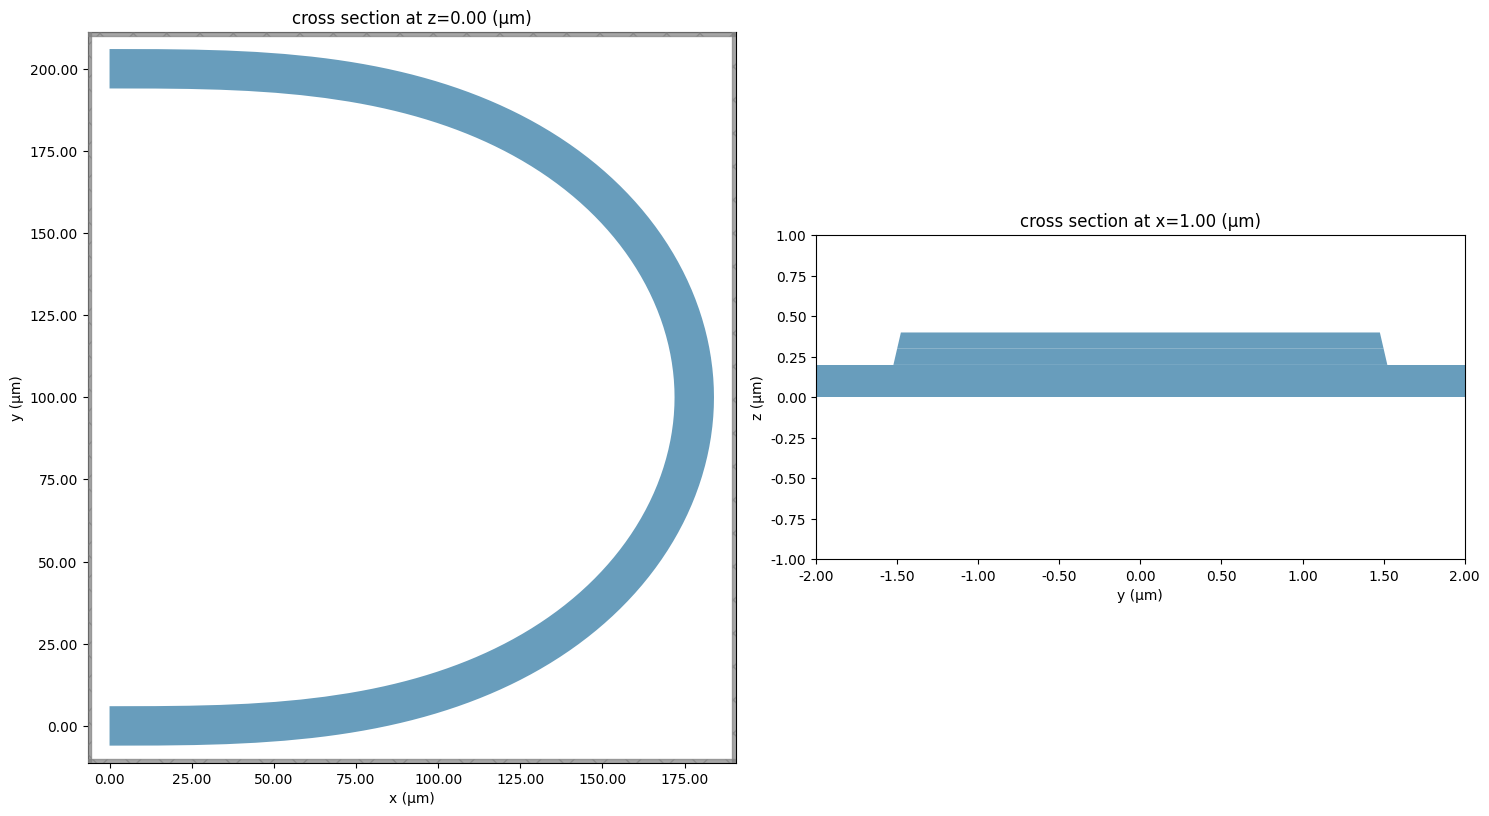

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = sim.plot(z= 0, ax=ax1)
ax1 = sim.plot(x= 1, ax=ax2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-1, 1)

Total number of grid points (millions): 6.5e+02


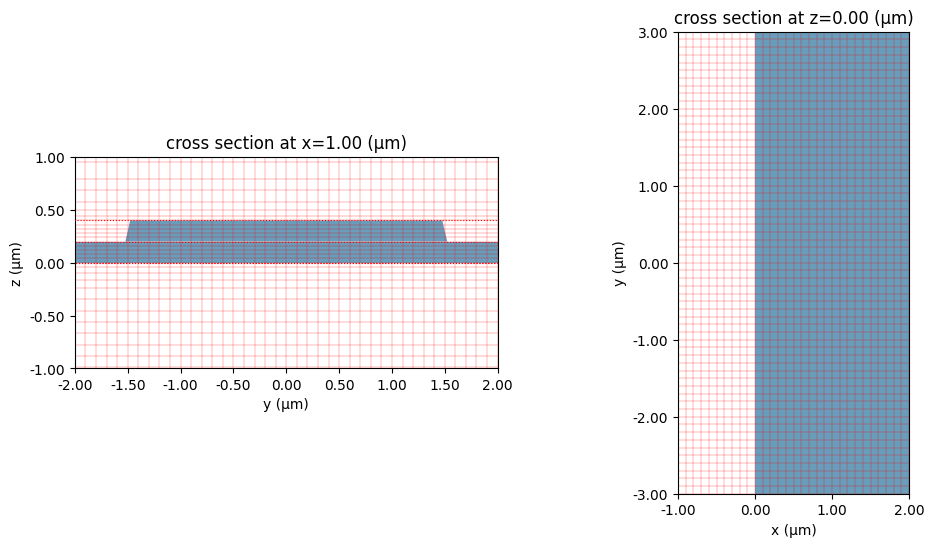

In [6]:
# Plot simulation and overlay grid in the yz and xy planes
def plot_sim_grid(sim):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sim.plot(x=1, ax=ax[0])
    sim.plot_grid(x=1, ax=ax[0], lw=0.4, colors="r")
    ax[0].set_xlim(-2, 2)
    ax[0].set_ylim(-1, 1)
    sim.plot(z=0, ax=ax[1])
    sim.plot_grid(z=0, ax=ax[1], lw=0.4, colors="r")
    ax[1].set_xlim(-1, 2)
    ax[1].set_ylim(-3, 3)
    print(f"Total number of grid points (millions): {sim.num_cells / 1e6:1.2}")

    return ax

ax3 = plot_sim_grid(sim)

### Mode Solver

In [7]:
plane = td.Box(center=[1, 0 ,0], size=[0, 17, 7.75])

mode_spec = td.ModeSpec(
    num_modes=5,
    track_freq="central", 
    precision="double", 
    group_index_step=True
)

num_freqs = 10
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data = mode_solver.solve()

22:25:01 EEST WARNING: Use the remote mode solver with subpixel averaging for   
              better accuracy through 'tidy3d.web.run(...)' or the deprecated   
              'tidy3d.plugins.mode.web.run(...)'.                               

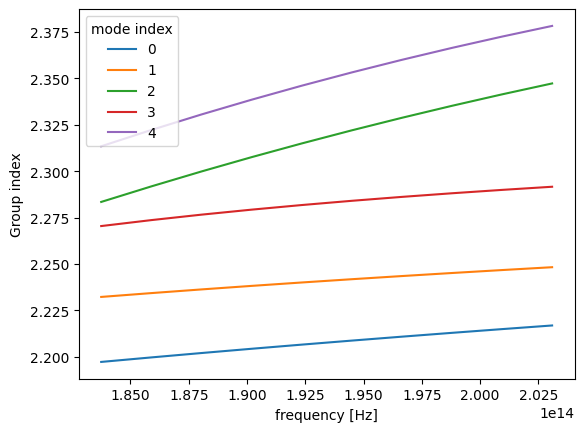

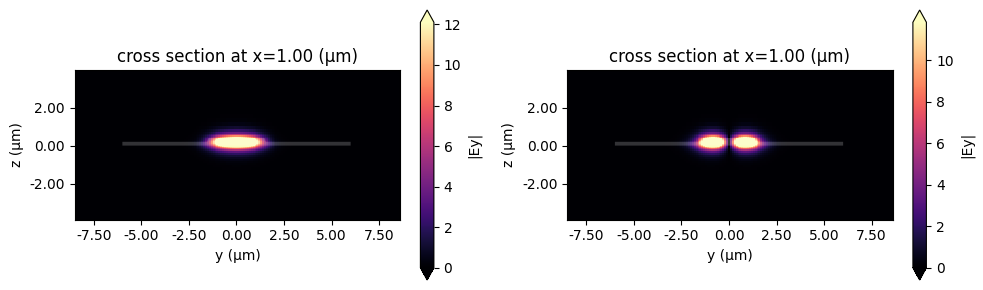

In [8]:
fig, ax = plt.subplots(1)
n_group = mode_data.n_group  # real part of the effective mode index
n_group.plot.line(x="f")
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
mode_solver.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax2)
plt.show()

## S-Matrix

Add the in and out ports

In [9]:
from tidy3d.plugins.smatrix.smatrix import Port

num_modes = 5

bot_out = Port(
    center=port_pos,
    size=port_size,
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="-",
    name="bot_out",
)

top_in = Port(
    center=[1, 0, 0],
    size=port_size,
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction="+",
    name="top_in",
)

ports = [bot_out, top_in]

In [10]:
from tidy3d.plugins.smatrix.smatrix import ComponentModeler

port_in = ("top_in",0)
port_out = ("bot_out",0)

run_only = [port_in]
modeler = ComponentModeler(
    simulation=sim, 
    ports=ports,

    freqs=[freq0], 
    verbose=True, 
    path_dir="data"
)

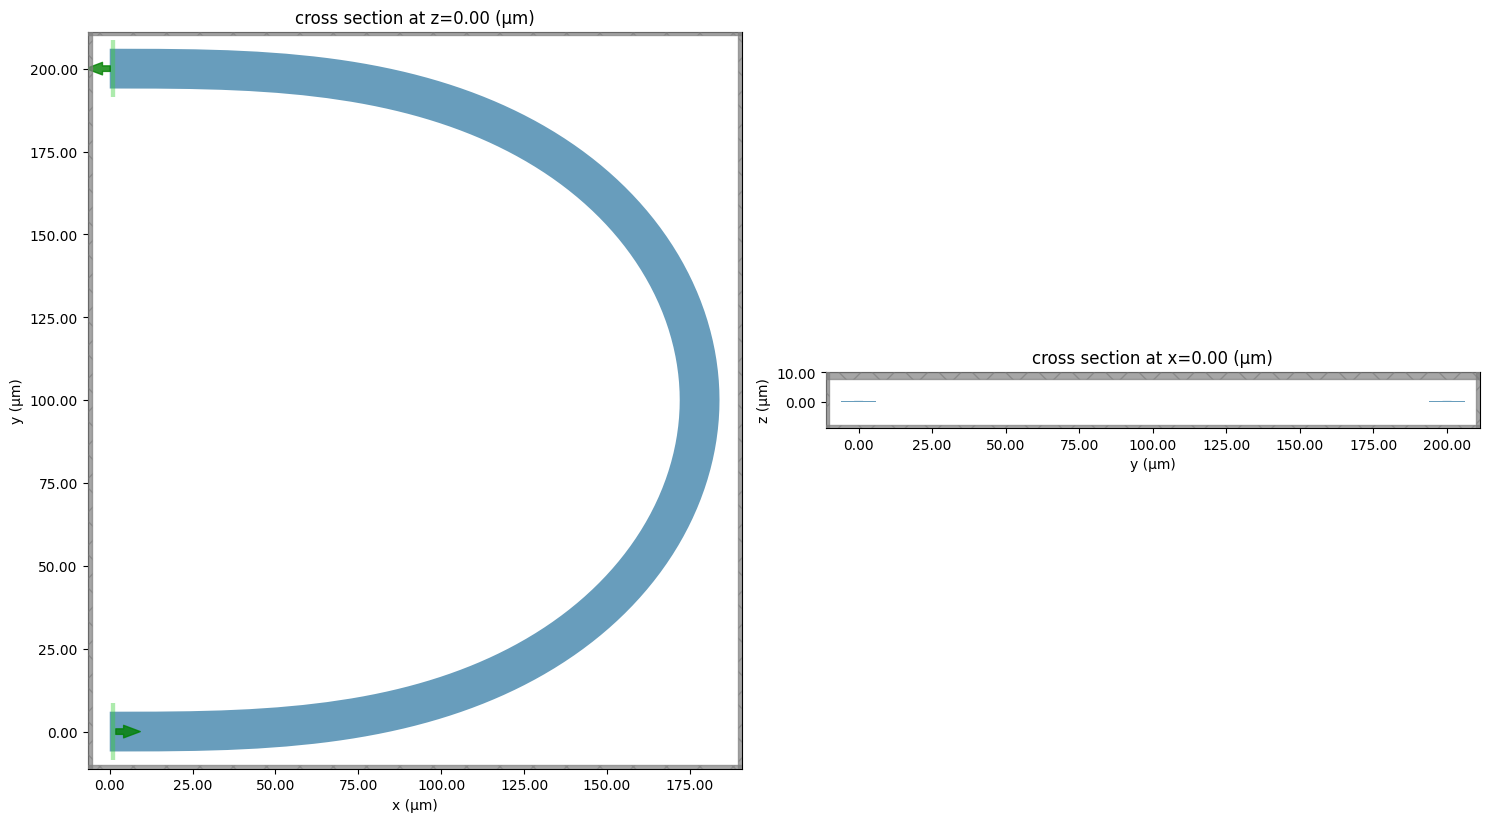

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = modeler.plot_sim(z=0, ax=ax1)
ax2 = modeler.plot_sim(x=0, ax=ax2)

In [127]:
# initializes job, puts task on server (but doesnt run it)
job = web.Job(simulation=sim, task_name="job")

# estimate the maximum cost
estimated_cost = web.estimate_cost(job.task_id)

print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

19:11:18 EEST Created task 'job' with task_id                                   
              'fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=951707;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=238138;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb\taskId]8;;\]8;id=951707;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb\=]8;;\]8;id=652201;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb\fdve]8;;\]8;id=951707;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb\-b9ebea05-9b]8;;\
              ]8;id=951707;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ebea05-9b67-41bb-8bb4-3e19311081eb\67-41bb-8bb4-3e19311081eb']8;;\.

19:11:19 EEST Task folder: ]8;id=514340;https://tidy3d.simulation.cloud/folders/folder-d369e6d4-a8e1-4f23-ae55-8a99c675b453\'default']8;;\.

Output()

19:11:22 EEST Maximum FlexCredit cost: 17.291. Minimum cost depends on task     
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:11:24 EEST Maximum FlexCredit cost: 17.291. Minimum cost depends on task     
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

The estimated maximum cost is 17.291 Flex Credits.


In [12]:
smatrix = modeler.run()

Output()

22:26:07 EEST Started working on Batch containing 10 tasks.

22:26:24 EEST Maximum FlexCredit cost: 172.889 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

22:56:07 EEST Batch complete.

Output()

22:56:23 EEST WARNING: Simulation final field decay value of 0.00189 is greater 
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

22:56:24 EEST WARNING: Simulation final field decay value of 0.00137 is greater 
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

              WARNING: Simulation final field decay value of 0.00035 is greater 
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

22:56:25 EEST WARNING: Simulation final field decay value of 0.000663 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

              WARNING: Simulation final field decay value of 0.000404 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

22:56:26 EEST WARNING: Simulation final field decay value of 0.0294 is greater  
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

              WARNING: Simulation final field decay value of 0.0249 is greater  
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

              WARNING: Simulation final field decay value of 0.0126 is greater  
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

22:56:27 EEST WARNING: Simulation final field decay value of 0.0173 is greater  
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

              WARNING: Simulation final field decay value of 0.0135 is greater  
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

## Working with Scattering Matrix

The scattering matrix returned by the solve is an xr.DataArray relating the port names and mode_indices.
For example `smatrix.loc[dict(port_in=name1, mode_index_in=mode_index1, port_out=name2, mode_index_out=mode_index_2)]` gives the complex scattering matrix element.

For example:

In [8]:
smatrix.loc[dict(port_in="left_top", mode_index_in=0, port_out="right_bot", mode_index_out=0)]

<xarray.SMatrixDataArray (f: 1)>
array([0.33469842-0.61911778j])
Coordinates:
    port_out        <U9 'right_bot'
    port_in         <U9 'left_top'
    mode_index_out  int64 0
    mode_index_in   int64 0
  * f               (f) float64 1.934e+14

Alternatively, we can convert this into a numpy array:

In [9]:
S = np.squeeze(smatrix.values)
print(S.shape)

(4, 4)


We can inspect `S` and note that the diagonal elements are very small indicating low backscattering.

Summing each rows of the matrix should give 1.0 if no power was lost.

In [12]:
np.sum(abs(S) ** 2, axis=0)

array([0.98590153, 0.98590134, 0.98590724, 0.9859074 ])

There is a little power loss since the coupler was not optimized, most likely scattering from the bends and coupling region.

Finally, we can check whether `S` is close to unitary as expected. S times its Hermitian conjugate should be the identity matrix.

In [10]:
mat = S @ (np.conj(S.T))

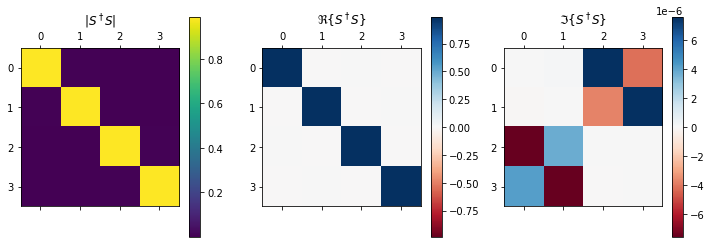

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3.5))
imabs = ax1.matshow(abs(mat))
vmax = np.abs(mat.real).max()
imreal = ax2.matshow(mat.real, cmap="RdBu", vmin=-vmax, vmax=vmax)
vmax = np.abs(mat.imag).max()
imimag = ax3.matshow(mat.imag, cmap="RdBu", vmin=-vmax, vmax=vmax)
ax1.set_title(r"$|S^\dagger S|$")
ax2.set_title(r"$\Re\{S^\dagger S\}$")
ax3.set_title(r"$\Im\{S^\dagger S\}$")
plt.colorbar(imabs, ax=ax1)
plt.colorbar(imreal, ax=ax2)
plt.colorbar(imimag, ax=ax3)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

It looks pretty close, but there seems to indeed be a bit of loss (expected).

## Viewing individual Simulation Data
To verify, we may want to take a look the individual simulation data.
For that, we can load up the batch and inspect the [SimulationData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) for each task.

[16:24:36] loading SimulationData from                             ]8;id=38186;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=864901;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-35cd21ba-c710-4a4b-82be-42b161393984v1.hdf5                

           WARNING: 'int' field name is deprecated and will be   ]8;id=388332;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=465787;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#497\497]8;;\
           removed in the future. Plese use field_name='E' and                  
           val='abs^2' for the same effect.                                     

[16:24:38] loading SimulationData from                             ]8;id=48658;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=994475;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-fb655fca-e9c2-4ae9-819d-6a15f80d1132v1.hdf5                

           WARNING: 'int' field name is deprecated and will be   ]8;id=517097;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=984589;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#497\497]8;;\
           removed in the future. Plese use field_name='E' and                  
           val='abs^2' for the same effect.                                     

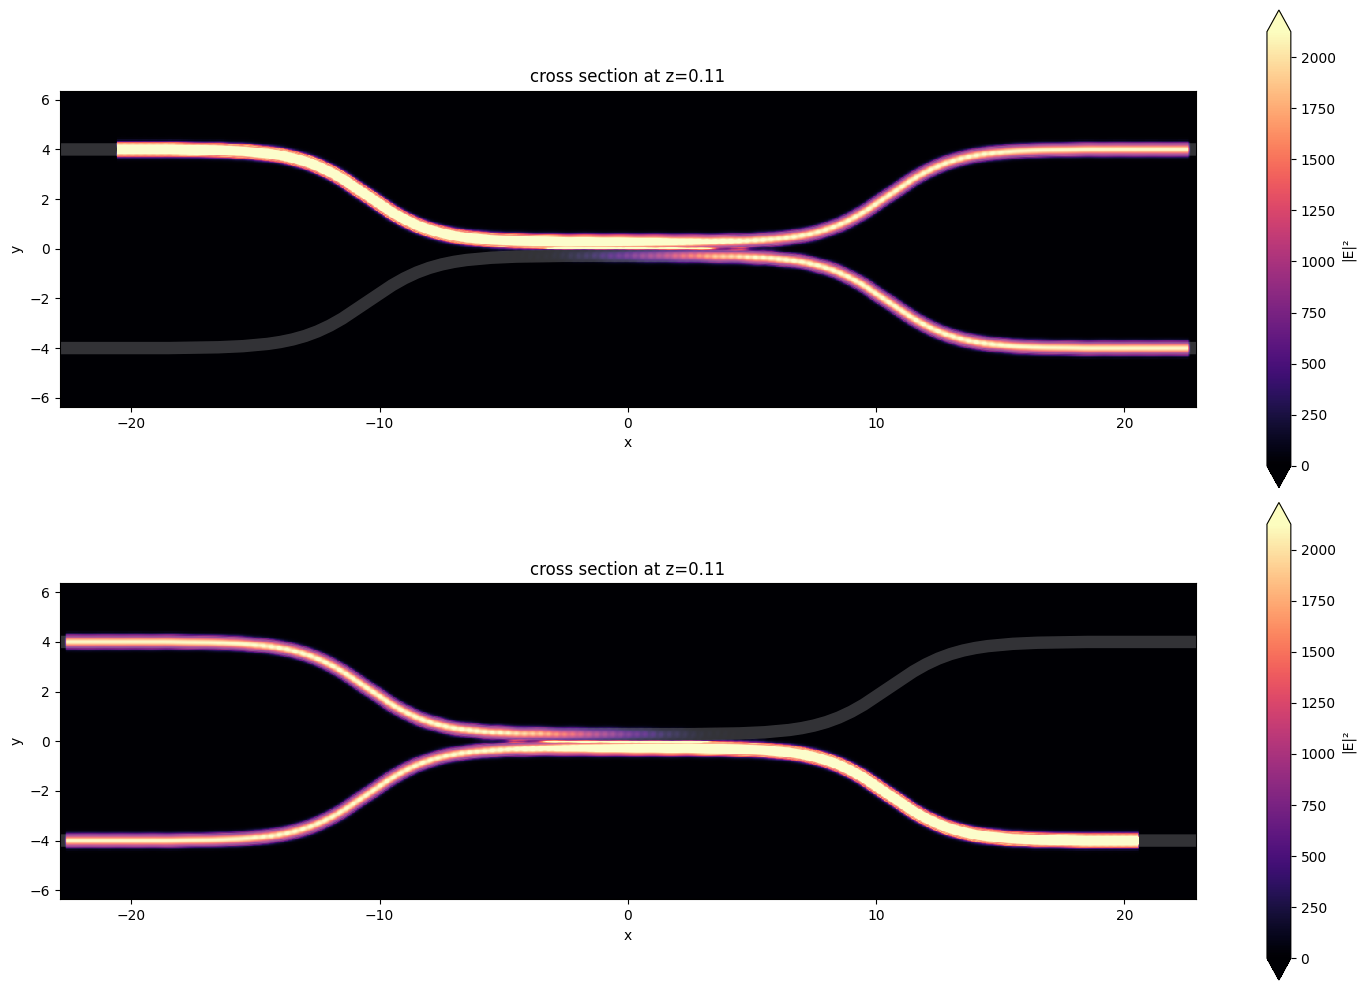

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = modeler.batch.load(path_dir="data")["smatrix_left_top_0"].plot_field(
    "field", field_name="E", val="abs^2", z=wg_height / 2, ax=ax1
)
ax2 = modeler.batch.load(path_dir="data")["smatrix_right_bot_0"].plot_field(
    "field", field_name="E", val="abs^2", z=wg_height / 2, ax=ax2
)

## Saving and Loading Results

Finally, we can save and load the component modeler from file to save the results.

[16:24:41] loading SimulationData from                             ]8;id=246800;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=997293;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-35cd21ba-c710-4a4b-82be-42b161393984v1.hdf5                

           WARNING: 'int' field name is deprecated and will be   ]8;id=398873;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=697561;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#497\497]8;;\
           removed in the future. Plese use field_name='E' and                  
           val='abs^2' for the same effect.                                     

[16:24:43] loading SimulationData from                             ]8;id=731028;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=179311;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-fb655fca-e9c2-4ae9-819d-6a15f80d1132v1.hdf5                

           WARNING: 'int' field name is deprecated and will be   ]8;id=410484;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=368210;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#497\497]8;;\
           removed in the future. Plese use field_name='E' and                  
           val='abs^2' for the same effect.                                     

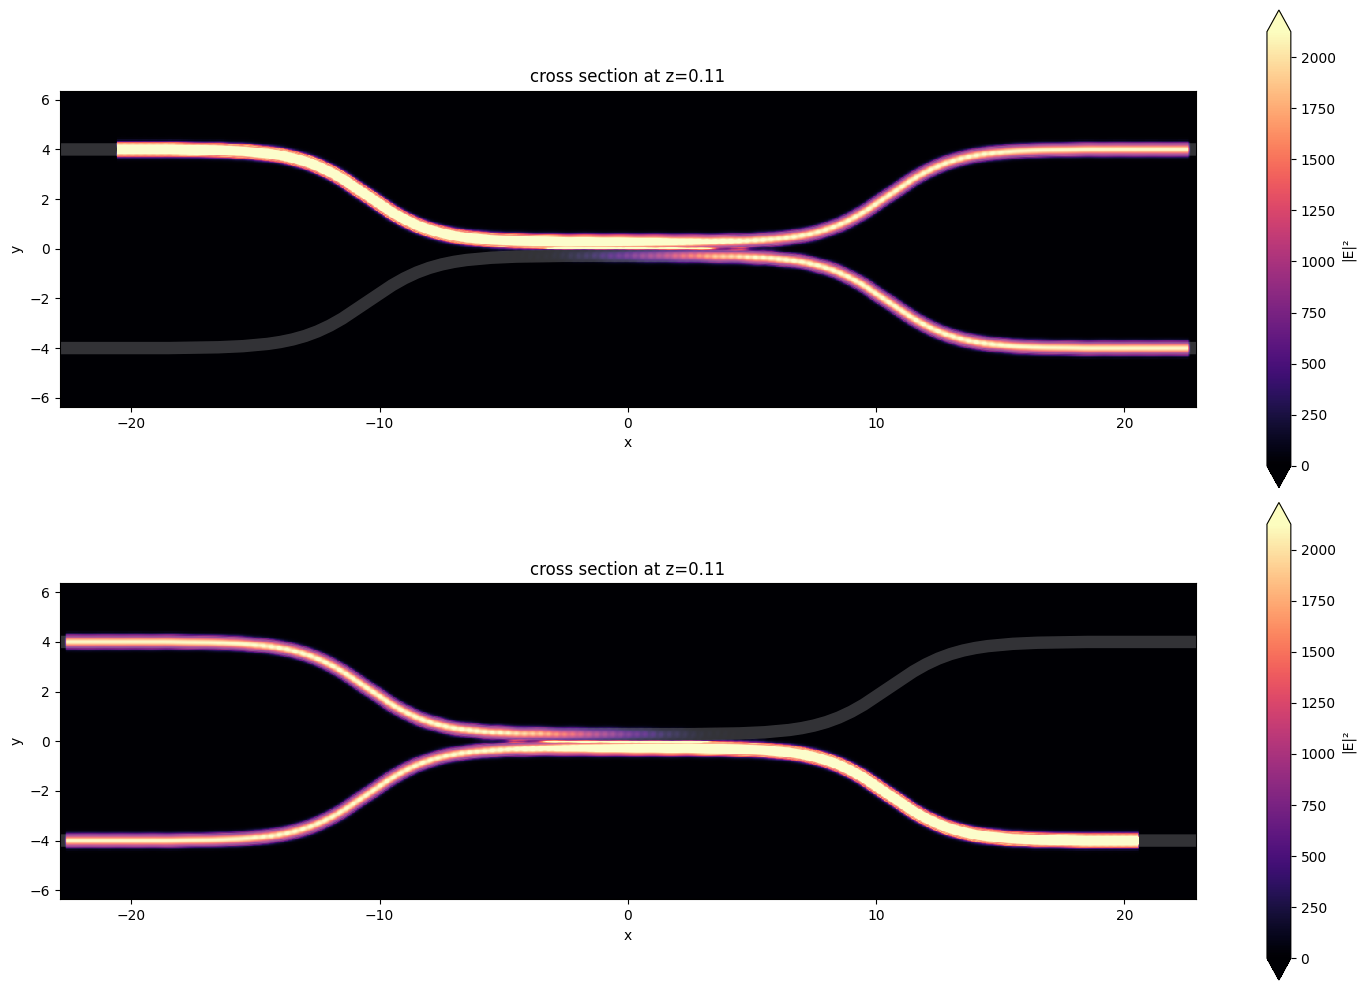

In [16]:
fname = "data/modeler.json"
modeler.to_file(fname)
modeler2 = ComponentModeler.from_file(fname)
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = modeler2.batch.load(path_dir="data")["smatrix_left_top_0"].plot_field(
    "field", "int", z=wg_height / 2, ax=ax1
)
ax2 = modeler2.batch.load(path_dir="data")["smatrix_right_bot_0"].plot_field(
    "field", "int", z=wg_height / 2, ax=ax2
)

## Element Mappings

If we wish, we can specify mappings between scattering matrix elements that we want to be equal up to a multiplicative factor.
We can define these as `element_mappings` in the `ComponentModeler`.

"Indices" are defined as a tuple of `(port_name: str, mode_index: int)`

"Elements" are defined as a tuple of output and input indices, respectively.

The element mappings are therefore defined as a tuple of `(element, element, value)` where the second `element` is set by the value of the 1st `element` times the supplied `value`.

As an example, let's define this element mapping from the example above to enforce that the coupling between bottom left to bottom right should be equal to the coupling between top left to top right.

In [17]:
# these are the "indices" in our scattering matrix
left_top = ("left_top", 0)
right_top = ("right_top", 0)
left_bot = ("left_bot", 0)
right_bot = ("right_bot", 0)

# we define the scattering matrix elements coupling the top ports and bottom ports as pairs of these indices
top_coupling_r2l = (left_top, right_top)
bot_coupling_r2l = (left_bot, right_bot)
top_coupling_l2r = (right_top, left_top)
bot_coupling_l2r = (right_bot, left_bot)

# map the top coupling to the bottom coupling with a multiplicative factor of +1
map_horizontal_l2r = (top_coupling_l2r, bot_coupling_l2r, +1)
map_horizontal_r2l = (top_coupling_r2l, bot_coupling_r2l, +1)

element_mappings = (map_horizontal_l2r, map_horizontal_r2l)

In [18]:
# run the component modeler again
modeler = ComponentModeler(
    simulation=sim,
    ports=ports,
    freqs=[freq0],
    element_mappings=element_mappings,
    verbose=True,
    path_dir="data",
)
smatrix = modeler.run()

[16:24:45] Created task 'smatrix_right_top_0' with task_id         ]8;id=717615;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=373048;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1'.                       

           View task using web UI at                               ]8;id=770145;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=742108;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=816404;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=90673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1\taskId]8;;\]8;id=816404;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1\=]8;;\]8;id=483858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1\fdve]8;;\]8;id=816404;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1\-]8;;\              
           ]8;id=816404;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1\4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1']8;;\.                             

Output()

[16:24:46] Created task 'smatrix_right_bot_0' with task_id         ]8;id=360866;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=177422;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1'.                       

           View task using web UI at                               ]8;id=567876;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=81100;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=462624;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=400492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1\taskId]8;;\]8;id=462624;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1\=]8;;\]8;id=419919;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1\fdve]8;;\]8;id=462624;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1\-]8;;\              
           ]8;id=462624;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1\6609948e-9edb-4cfd-9132-8c0de1e12b27v1']8;;\.                             

Output()

           Created task 'smatrix_left_top_0' with task_id          ]8;id=99932;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=793748;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1'.                       

           View task using web UI at                               ]8;id=396306;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=670730;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=710549;https://tidy3d.simulation.cloud/workbench?taskId=fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=352042;https://tidy3d.simulation.cloud/workbench?taskId=fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1\taskId]8;;\]8;id=710549;https://tidy3d.simulation.cloud/workbench?taskId=fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1\=]8;;\]8;id=247893;https://tidy3d.simulation.cloud/workbench?taskId=fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1\fdve]8;;\]8;id=710549;https://tidy3d.simulation.cloud/workbench?taskId=fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1\-]8;;\              
           ]8;id=710549;https://tidy3d.simulation.cloud/workbench?taskId=fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1\458d2239-0779-4d48-92b1-f7c0d021609ev1']8;;\.                             

Output()

[16:24:47] Created task 'smatrix_left_bot_0' with task_id          ]8;id=603725;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=405732;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1'.                       

           View task using web UI at                               ]8;id=314674;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=922543;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=777057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=134650;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1\taskId]8;;\]8;id=777057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1\=]8;;\]8;id=6556;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1\fdve]8;;\]8;id=777057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1\-]8;;\              
           ]8;id=777057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1\ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1']8;;\.                             

Output()

[16:24:48] Started working on Batch.                            ]8;id=263637;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=385381;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[16:25:12] Maximum FlexCredit cost: 1.763 for the whole batch.  ]8;id=174349;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=986673;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[16:28:11] Batch complete.                                      ]8;id=860697;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=299807;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

[16:28:18] loading SimulationData from                             ]8;id=248880;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=251160;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           ./fdve-4ae19a0b-6656-4767-b012-1dc3e17e3dfdv1.hdf5                   

Output()

[16:28:24] loading SimulationData from                             ]8;id=782619;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=998930;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           ./fdve-6609948e-9edb-4cfd-9132-8c0de1e12b27v1.hdf5                   

Output()

[16:28:30] loading SimulationData from                             ]8;id=271337;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=484755;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           ./fdve-458d2239-0779-4d48-92b1-f7c0d021609ev1.hdf5                   

Output()

[16:28:36] loading SimulationData from                             ]8;id=803965;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=757363;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           ./fdve-ccc9701f-20f7-4937-a40b-bff4b9e7e42bv1.hdf5                   

The resulting scattering matrix will have the element mappings applied, we can check this explicitly.

In [19]:
# assert that the horizontal couping elements are exactly equal
LT_RT = np.squeeze(smatrix.loc[dict(port_in="left_top", port_out="right_top")])
LB_RB = np.squeeze(smatrix.loc[dict(port_in="left_bot", port_out="right_bot")])
print(f"top to top coupling       = {LT_RT:.5f}")
print(f"bottom to bottom coupling = {LB_RB:.5f}")

assert np.isclose(LT_RT, LB_RB)

top to top coupling       = -0.61725-0.32981j
bottom to bottom coupling = -0.61725-0.32981j


## Incomplete Scattering Matrix
Finally, to exclude some rows of the scattering matrix, one can supply a `run_only` paramteter to the `ComponentModeler`.

`run_only` contains the scattering matrix indices that the user wants to run as a source. If any indices are excluded, they will not be run.

For example, if one wants to compute scattering matrix elements from only the ports on the left hand side, the `run_only` could be defined as follows.

In [20]:
run_only = (left_top, left_bot)
modeler = ComponentModeler(
    simulation=sim, ports=ports, freqs=[freq0], run_only=run_only, verbose=True, path_dir="data"
)
smatrix = modeler.run()

[16:28:40] Created task 'smatrix_left_top_0' with task_id          ]8;id=498668;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=93889;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1'.                       

           View task using web UI at                               ]8;id=677780;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674938;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=895873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=219532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1\taskId]8;;\]8;id=895873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1\=]8;;\]8;id=712813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1\fdve]8;;\]8;id=895873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1\-]8;;\              
           ]8;id=895873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1\f39c4ead-9fac-421b-abbf-60900dcbde93v1']8;;\.                             

Output()

           Created task 'smatrix_left_bot_0' with task_id          ]8;id=797428;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=284095;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1'.                       

           View task using web UI at                               ]8;id=13205;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=97499;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=412500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=353209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1\taskId]8;;\]8;id=412500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1\=]8;;\]8;id=836542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1\fdve]8;;\]8;id=412500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1\-]8;;\              
           ]8;id=412500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1\5dfff954-b1b1-4089-92a3-bb2e14376305v1']8;;\.                             

Output()

[16:28:42] Started working on Batch.                            ]8;id=149874;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=413163;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[16:28:51] Maximum FlexCredit cost: 0.881 for the whole batch.  ]8;id=780440;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=476839;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[16:30:16] Batch complete.                                      ]8;id=745877;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=274239;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

[16:30:24] loading SimulationData from                             ]8;id=283697;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=471712;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           ./fdve-f39c4ead-9fac-421b-abbf-60900dcbde93v1.hdf5                   

Output()

[16:30:29] loading SimulationData from                             ]8;id=10692;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=58708;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           ./fdve-5dfff954-b1b1-4089-92a3-bb2e14376305v1.hdf5                   

The resulting scattering matrix will have all zeros for elements corresponding to ports not included in the in `run_only` inputs.

In [21]:
s_matrix_left_top = np.squeeze(smatrix.loc[dict(port_in="left_top")].values)

print("output from run_only port     : \n", s_matrix_left_top)

assert "right_top" not in smatrix.coords["port_in"]

output from run_only port     : 
 [-0.61725057-0.32980806j  0.33469665-0.61911863j  0.00119965+0.02065445j
 -0.00907913-0.01718773j]
